In [1]:
import PythonicDISORT
import scipy as sc
import plotly as pl
import autograd as ag
import autograd.numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from numpy.polynomial.legendre import Legendre
from PythonicDISORT.subroutines import atleast_2d_append
from math import pi

# Matplotlib default colors
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

# Table of Contents
* [Load dataset](#Load-dataset)
* [Parameters and setup](#Parameters-and-setup)
	* [Figure 2](#Figure-2)
* [Exact coupling coefficients](#Exact-coupling-coefficients)
	* [Figure 1](#Figure-1)
* [Baseline two-stream closures](#Baseline-two-stream-closures)
	* [Figure 3](#Figure-3)
* [Numerical Optimization (for one set of problem parameters)](#Numerical-Optimization-%28for-one-set-of-problem-parameters%29)
	* [Figure 4](#Figure-4)
* [Contour and 3D plots of dataset](#Contour-and-3D-plots-of-dataset)
	* [Figure 5](#Figure-5)
		* [Figure 5 but as an INTERACTIVE 3D plot](#Figure-5-but-as-an-INTERACTIVE-3D-plot)
	* [Figure 6](#Figure-6)
		* [Figure 6 but as an INTERACTIVE 3D plot](#Figure-6-but-as-an-INTERACTIVE-3D-plot)
* [Diffusion Approximation](#Diffusion-Approximation)
	* [Figure 7](#Figure-7)


# Load dataset

In [2]:
data = np.load("two-streams_revisited.npz")

(
    # Inputs
    g_data,
    tau0_data,
    omega_data,
    mu0_data,
    # Reflectance
    R_true_data,
    R_opt2_data,
    R_opt4_data,
    R_Zdun_data,
    R_Edd_data,
    R_CC1_data,
    # Transmittance
    T_true_data,
    T_opt2_data,
    T_opt4_data,
    T_Zdun_data,
    T_Edd_data,
    T_CC1_data,
    # Optimized gammas
    gamma1_opt_data,
    gamma2_opt_data,
    gamma1p_opt_data,
    gamma1m_opt_data,
    gamma2p_opt_data,
    gamma2m_opt_data,
) = (values for values in data.values())

# Parameters and setup

**Choose problem parameters**

In [3]:
# Problem parameters (same as in dataset)
Ng = 31
Nt = 22
No = 28
Nm = 25

g_data = np.linspace(0.65, 0.95, Ng)
tau0_data = 10 ** np.linspace(1, -2, Nt)
omega_data = 1 - 10 ** np.linspace(-6, 0, No + 3)[:-3]
mu0_data = np.cos(np.linspace(0, np.arccos(0.01), Nm))

In [4]:
g = np.random.choice(g_data)
tau0 = np.random.choice(tau0_data)
omega = np.random.choice(omega_data)
mu0 = np.random.choice(mu0_data)

print(g, tau0, omega, mu0)

0.76 0.2682695795279726 0.9999960189282945 0.13960897691953444


## Figure 2

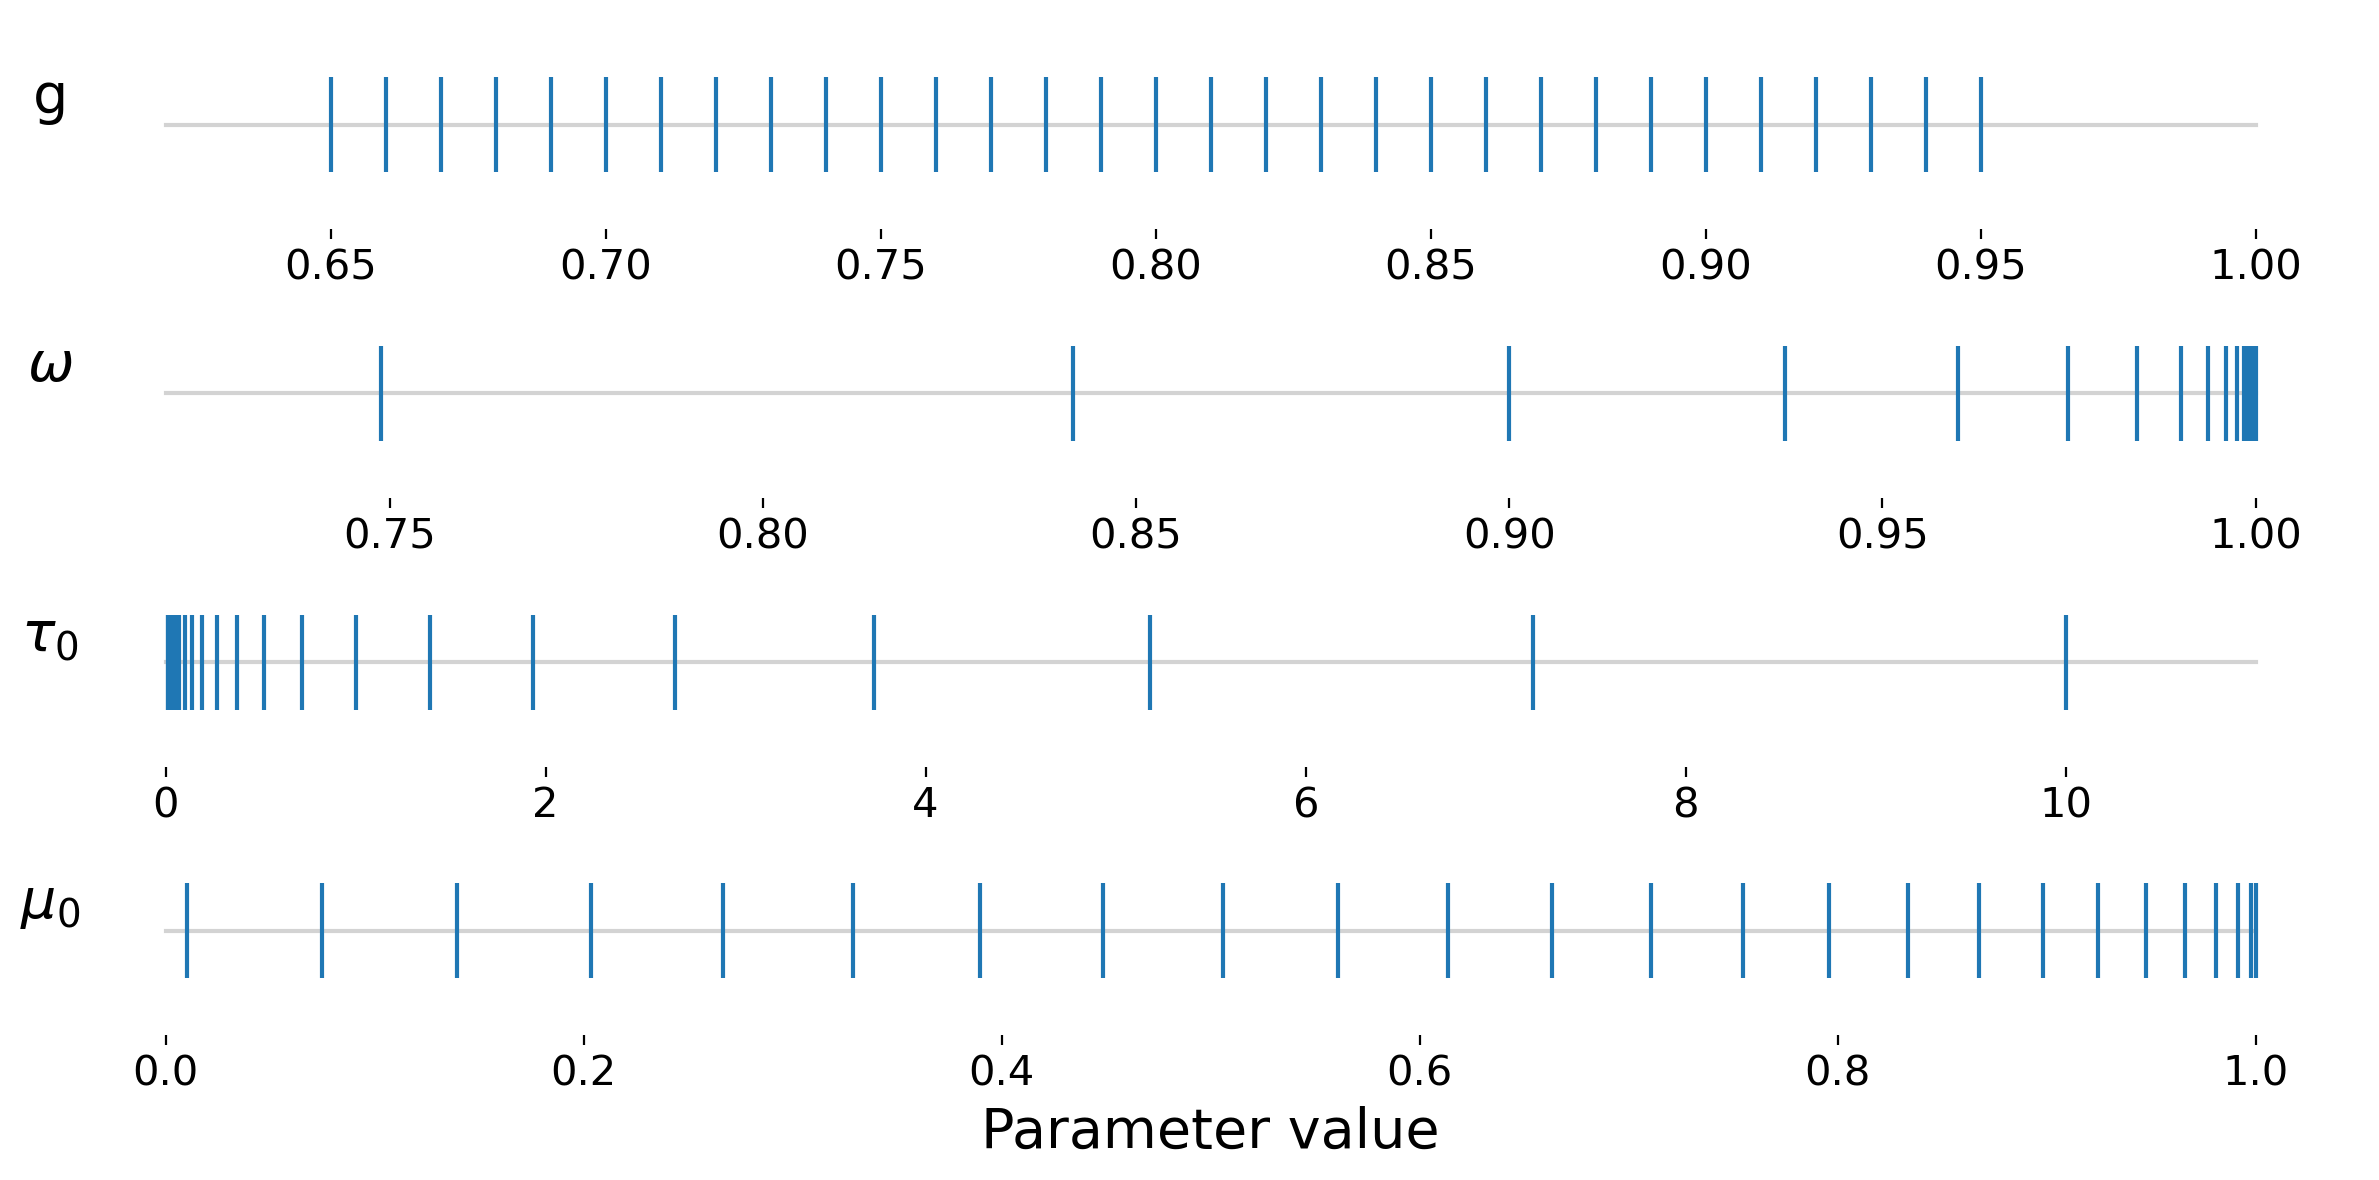

In [5]:
# Plot problem paramaters (Fig. 2)
fig = plt.figure(figsize=(12, 6), dpi=200)
ax1 = plt.subplot(411)
plt.plot([0.62, 1], np.ones(2), color="lightgrey")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_yaxis().set_ticks([])
plt.eventplot(g_data, orientation='horizontal')
plt.xticks(fontsize=15)
plt.ylabel("g", fontsize=20, rotation=0)
ax1.tick_params(labelleft=False)
ax2 = plt.subplot(412)
plt.plot([0.72, 1], np.ones(2), color="lightgrey")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_ticks([])
plt.eventplot(omega_data, orientation='horizontal')
plt.xticks(fontsize=15)
plt.ylabel(r"$\omega$", fontsize=20, rotation=0)
ax2.tick_params(labelleft=False)
ax3 = plt.subplot(413)
plt.plot([0, 11], np.ones(2), color="lightgrey")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.get_yaxis().set_ticks([])
plt.eventplot(tau0_data, orientation='horizontal')
plt.xticks(fontsize=15)
plt.ylabel(r"$\tau_0$", fontsize=20, rotation=0)
ax3.tick_params(labelleft=False)
ax4 = plt.subplot(414)
plt.plot([0, 1], np.ones(2), color="lightgrey")
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.get_yaxis().set_ticks([])
plt.eventplot(mu0_data, orientation='horizontal')
plt.xticks(fontsize=15)
plt.ylabel(r"$\mu_0$", fontsize=20, rotation=0)
plt.xlabel("Parameter value", fontsize=20)
ax4.tick_params(labelleft=False)

fig.tight_layout(h_pad=0)

**Choose computational parameters**

In [6]:
NQuad = 106  # Should choose prime number X 2; can probably be decreased
NLeg = NQuad

Ntau = 200  # Number of tau test points, mostly for plotting
tau_arr = np.linspace(0, tau0, Ntau)

In [7]:
# Call high resolution solver
Leg_coeffs_all = g ** np.arange(250) # Henyey-Greenstein phase function Legendre coefficients
I0 = 1 / mu0

flux_up, flux_down, u0 = PythonicDISORT.pydisort(
    tau0,
    omega,
    NQuad,
    Leg_coeffs_all,
    mu0,
    I0,
    0,
    only_flux=True,
    f_arr=Leg_coeffs_all[NQuad],
    _autograd_compatible=True,
)[1:]

N = NQuad // 2
mu_arr_pos, weights_mu = PythonicDISORT.subroutines.Gauss_Legendre_quad(N)

In [8]:
# Compute backscattering ratio beta0
def S(Leg_coeffs):
    NLeg = len(Leg_coeffs)
    ell = np.arange(1, NLeg, 2, dtype="int64")
    t_ell = (-1) ** ((ell - 1) / 2) * (
        sc.special.factorial2(ell) / (sc.special.factorial2(ell - 1) * ell * (ell + 1))
    )
    coeffs = np.zeros(NLeg)
    coeffs[ell] = (2 * ell + 1) * t_ell * Leg_coeffs[ell]
    return Legendre(coeffs)

beta = lambda mu0: (1 / 2) * (1 + S(Leg_coeffs_all)(-mu0)) # Backscattering ratio function
beta0 = beta(mu0)

**Formula (12) to compute fluxes and consequently reflectance and transmittance (and absorption)**

In [9]:
# Formula (12) to compute fluxes
def gen_constcoeffs_diffusefluxes(
    g1p, g1m, g2p, g2m, g3, incident_flux, omega, tau0, mu0, g4=None
):
    if g4 == None:
        g4 = 1 - g3
    
    k = np.sqrt(g1p**2 + 2 * g1p * g1m + g1m**2 - 4 * g2p * g2m + 0j)
    lp = (g1p - g1m + k) / 2
    lm = (g1p - g1m - k) / 2
    a1 = 2 * g2m * ((g1p * g4 + g2p * g3) * mu0 + g4)
    a2 = 2 * g2p * ((g1m * g3 + g2m * g4) * mu0 - g3)
    a3 = g1p + g1m + k
    a4 = g1p + g1m - k
    a5 = (g1m * g3 + g2m * g4) * mu0 - g3
    a6 = (g1p * g4 + g2p * g3) * mu0 + g4
    a7 = (g1p * g1m - g2p * g2m) * mu0**2 + (g1m - g1p) * mu0 - 1
    #print(lp, lm)

    if np.real(lp) >= 0 and np.real(lm) >= 0:
        denom = a7 * (a3 * np.exp(-lm * tau0) - a4 * np.exp(-lp * tau0))
        if np.abs(denom) < 1e-15:
            denom_reciprocal = 0
        else:
            denom_reciprocal = 1 / denom
        Fp = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a1 * (np.exp(lp * (tau - tau0)) - np.exp(lm * (tau - tau0)))
                - a5
                * (
                    a3
                    * (
                        np.exp(lp * (tau - tau0) - tau0 / mu0 - lm * tau0)
                        - np.exp(-tau / mu0 - lm * tau0)
                    )
                    - a4
                    * (
                        np.exp(lm * (tau - tau0) - tau0 / mu0 - lp * tau0)
                        - np.exp(-tau / mu0 - lp * tau0)
                    )
                )
            )
            * denom_reciprocal
        )
        Fm = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a2
                * (
                    np.exp(lm * (tau - tau0) - tau0 / mu0 - lp * tau0)
                    - np.exp(lp * (tau - tau0) - tau0 / mu0 - lm * tau0)
                )
                + a6
                * (
                    a3 * (np.exp(-tau / mu0 - lm * tau0) - np.exp(lm * (tau - tau0)))
                    - a4 * (np.exp(-tau / mu0 - lp * tau0) - np.exp(lp * (tau - tau0)))
                )
            )
            * denom_reciprocal
        )

    elif np.real(lp) >= 0 and np.real(lm) <= 0:
        denom = a7 * (a3 - a4 * np.exp(-k * tau0))  # lm - lp = -k
        if np.abs(denom) < 1e-15:
            denom_reciprocal = 0
        else:
            denom_reciprocal = 1 / denom
        Fp = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a1 * (np.exp(lp * tau - k * tau0) - np.exp(lm * tau))
                - a5
                * (
                    a3 * (np.exp(lp * (tau - tau0) - tau0 / mu0) - np.exp(-tau / mu0))
                    - a4
                    * (
                        np.exp(lm * tau - tau0 / mu0 - lp * tau0)
                        - np.exp(-k * tau0 - tau / mu0)
                    )
                )
            )
            * denom_reciprocal
        )
        Fm = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a2
                * (
                    np.exp(lm * tau - tau0 / mu0 - lp * tau0)
                    - np.exp(lp * (tau - tau0) - tau0 / mu0)
                )
                + a6
                * (
                    a3 * (np.exp(-tau / mu0) - np.exp(lm * tau))
                    - a4 * (np.exp(-k * tau0 - tau / mu0) - np.exp(lp * tau - k * tau0))
                )
            )
            * denom_reciprocal
        )

    elif np.real(lp) <= 0 and np.real(lm) >= 0:
        denom = a7 * (a3 * np.exp(k * tau0) - a4)  # lp - lm = k
        if np.abs(denom) < 1e-15:
            denom_reciprocal = 0
        else:
            denom_reciprocal = 1 / denom
        Fp = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a1 * (np.exp(lp * tau) - np.exp(k * tau0 + lm * tau))
                - a5
                * (
                    a3
                    * (
                        np.exp(lp * tau - tau0 / mu0 - lm * tau0)
                        - np.exp(k * tau0 - tau / mu0)
                    )
                    - a4 * (np.exp(lm * (tau - tau0) - tau0 / mu0) - np.exp(-tau / mu0))
                )
            )
            * denom_reciprocal
        )
        Fm = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a2
                * (
                    np.exp(lm * (tau - tau0) - tau0 / mu0)
                    - np.exp(lp * tau - tau0 / mu0 - lm * tau0)
                )
                + a6
                * (
                    a3 * (np.exp(k * tau0 - tau / mu0) - np.exp(k * tau0 + lm * tau))
                    - a4 * (np.exp(-tau / mu0) - np.exp(lp * tau))
                )
            )
            * denom_reciprocal
        )

    else:
        denom = a7 * (a3 * np.exp(lp * tau0) - a4 * np.exp(lm * tau0))
        if np.abs(denom) < 1e-15:
            denom_reciprocal = 0
        else:
            denom_reciprocal = 1 / denom
        Fp = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a1 * (np.exp(lp * tau + lm * tau0) - np.exp(lp * tau0 + lm * tau))
                - a5
                * (
                    a3
                    * (
                        np.exp((lp * mu0 * tau - tau0) / mu0)
                        - np.exp((lp * mu0 * tau0 - tau) / mu0)
                    )
                    - a4
                    * (
                        np.exp((lm * mu0 * tau - tau0) / mu0)
                        - np.exp((lm * mu0 * tau0 - tau) / mu0)
                    )
                )
            )
            * denom_reciprocal
        )
        Fm = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a2
                * (
                    np.exp((lm * mu0 * tau - tau0) / mu0)
                    - np.exp((lp * mu0 * tau - tau0) / mu0)
                )
                + a6
                * (
                    a3
                    * (
                        np.exp((lp * mu0 * tau0 - tau) / mu0)
                        - np.exp(lp * tau0 + lm * tau)
                    )
                    - a4
                    * (
                        np.exp((lm * mu0 * tau0 - tau) / mu0)
                        - np.exp(lp * tau + lm * tau0)
                    )
                )
            )
            * denom_reciprocal
        )
        
    return Fp, Fm

In [10]:
# Function to compute R, T (and A)
def RTA_constcoeffs_diffusefluxes(g1p, g1m, g2p, g2m, g3, omega, tau0, mu0, g4=None):
    if g4 == None:
        g4 = 1 - g3

    Fp, Fm = gen_constcoeffs_diffusefluxes(
        g1p, g1m, g2p, g2m, g3, 1, omega, tau0, mu0, g4
    )

    R = Fp(0)
    T = Fm(tau0)
    A = 1 - R - T
    return R, T, A

# Exact coupling coefficients

In [11]:
# Implement exact coupling coefficients
S_cache = S(Leg_coeffs_all)(mu_arr_pos)

D1p = (
    lambda tau: (2 * pi)
    * (1 - omega / 2 * (1 + S_cache))
    * weights_mu
    @ atleast_2d_append(u0(tau))[:N, :]
)
D2m = (
    lambda tau: (2 * pi)
    * (omega / 2)
    * (1 - S_cache)
    * weights_mu
    @ atleast_2d_append(u0(tau))[N:, :]
)
D2p = (
    lambda tau: (2 * pi)
    * (omega / 2)
    * (1 - S_cache)
    * weights_mu
    @ atleast_2d_append(u0(tau))[:N, :]
)
D1m = (
    lambda tau: (2 * pi)
    * (1 - omega / 2 * (1 + S_cache))
    * weights_mu
    @ atleast_2d_append(u0(tau))[N:, :]
)


def gamma1p(tau):
    tau = np.atleast_1d(tau)
    Fp = flux_up(tau)
    return np.squeeze(
        np.divide(
            D1p(tau),
            Fp,
            out=np.zeros_like(tau, dtype=np.float64),
            where=Fp != 0,
            casting="unsafe",
        )
    )[()]


def gamma1m(tau):
    tau = np.atleast_1d(tau)
    Fm = flux_down(tau)[0]
    return np.squeeze(
        np.divide(
            D1m(tau),
            Fm,
            out=np.zeros_like(tau, dtype=np.float64),
            where=Fm != 0,
            casting="unsafe",
        )
    )[()]


def gamma2p(tau):
    tau = np.atleast_1d(tau)
    Fp = flux_up(tau)
    return np.squeeze(
        np.divide(
            D2p(tau),
            Fp,
            out=np.zeros_like(tau, dtype=np.float64),
            where=Fp != 0,
            casting="unsafe",
        )
    )[()]


def gamma2m(tau):
    tau = np.atleast_1d(tau)
    Fm = flux_down(tau)[0]
    return np.squeeze(
        np.divide(
            D2m(tau),
            Fm,
            out=np.zeros_like(tau, dtype=np.float64),
            where=Fm != 0,
            casting="unsafe",
        )
    )[()]


def gamma1(tau):
    tau = np.atleast_1d(tau)
    Fm = flux_down(tau)[0]
    Fp = flux_up(tau)
    denom = (Fp - Fm) * (Fp + Fm)
    return np.squeeze(
        np.divide(
            Fp * (D1p(tau) - D2m(tau)) + Fm * (D2p(tau) - D1m(tau)),
            denom,
            out=np.zeros_like(tau, dtype=np.float64),
            where=np.abs(denom) != 0,
            casting="unsafe",
        )
    )[()]


def gamma2(tau):
    tau = np.atleast_1d(tau)
    Fm = flux_down(tau)[0]
    Fp = flux_up(tau)
    denom = (Fp - Fm) * (Fp + Fm)
    return np.squeeze(
        np.divide(
            Fm * (D1p(tau) - D2m(tau)) + Fp * (D2p(tau) - D1m(tau)),
            denom,
            out=np.zeros_like(tau, dtype=np.float64),
            where=np.abs(denom) != 0,
            casting="unsafe",
        )
    )[()]

**Verify exact coupling coefficients**

In [12]:
# Verify exact general two-stream equations

def RHS_exact(tau, F):
    plus = (
        gamma1p(tau) * F[0, :]
        - gamma2m(tau) * F[1, :]
        - omega * I0 * beta0 * np.exp(-tau / mu0)
    )
    minus = (
        gamma2p(tau) * F[0, :]
        - gamma1m(tau) * F[1, :]
        + omega * I0 * (1 - beta0) * np.exp(-tau / mu0)
    )
    return np.vstack((plus, minus))


sol_exact = sc.integrate.solve_bvp(
    RHS_exact,
    lambda ya, yb: np.array([ya[-1], yb[0]]),
    tau_arr,
    np.zeros((2, Ntau)),
    tol=1e-5,
    max_nodes=int(1e4),
    verbose=2,
)

print()
print(
    "Down flux max pointwise error =",
    np.max(np.abs(flux_up(tau_arr)[:-1] - sol_exact.sol(tau_arr)[0, :-1])),
)
print(
    "Up flux max pointwise error =",
    np.max(np.abs(flux_down(tau_arr)[0][:-1] - sol_exact.sol(tau_arr)[1, :-1])),
)


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          8.22e-05       0.00e+00          200             2       
       2          1.77e-05       0.00e+00          202             2       
       3          7.75e-06       0.00e+00          204             0       
Solved in 3 iterations, number of nodes 204. 
Maximum relative residual: 7.75e-06 
Maximum boundary residual: 0.00e+00

Down flux max pointwise error = 8.500389947485587e-09
Up flux max pointwise error = 5.8111106482350294e-09


In [13]:
# Verify exact symmetric two-stream equations (decrease `tol` if this does not converge)

def RHS_exact(tau, F):
    plus = (
        gamma1(tau) * F[0, :]
        - gamma2(tau) * F[1, :]
        - omega * I0 * beta0 * np.exp(-tau / mu0)
    )
    minus = (
        gamma2(tau) * F[0, :]
        - gamma1(tau) * F[1, :]
        + omega * I0 * (1 - beta0) * np.exp(-tau / mu0)
    )
    return np.vstack((plus, minus))


sol_exact = sc.integrate.solve_bvp(
    RHS_exact,
    lambda ya, yb: np.array([ya[-1], yb[0]]),
    tau_arr,
    np.zeros((2, Ntau)),
    tol=1e-3,
    max_nodes=int(1e4),
    verbose=2,
)

print()
print(
    "Down flux max pointwise error =",
    np.max(np.abs(flux_up(tau_arr)[:-1] - sol_exact.sol(tau_arr)[0, :-1])),
)
print(
    "Up flux max pointwise error =",
    np.max(np.abs(flux_down(tau_arr)[0][:-1] - sol_exact.sol(tau_arr)[1, :-1])),
)


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          8.22e-05       0.00e+00          200             2       
       2          1.77e-05       0.00e+00          202             2       
       3          7.75e-06       0.00e+00          204             0       
Solved in 3 iterations, number of nodes 204. 
Maximum relative residual: 7.75e-06 
Maximum boundary residual: 0.00e+00

Down flux max pointwise error = 9.626421909603167e-09
Up flux max pointwise error = 7.108803101729677e-09


**Plot exact coefficients**

In [14]:
# Analytically continue and compute exact coupling coefficients
gamma1p_tau = gamma1p(tau_arr[:-1])
gamma1p_tau = np.append(
    gamma1p_tau,
    ((2 * pi) * (1 - omega / 2 * (1 + S_cache)) * weights_mu@ ag.jacobian(u0)(tau0)[:N])
    / ag.grad(flux_up)(tau0),
)
gamma1m_tau = gamma1m(tau_arr[1:])
gamma1m_tau = np.insert(
    gamma1m_tau,
    0,
    ((2 * pi) * (1 - omega / 2 * (1 + S_cache)) * weights_mu @ ag.jacobian(u0)(0.0)[N:])
    / ag.grad(lambda tau: flux_down(tau)[0])(0.0),
)
gamma2p_tau = gamma2p(tau_arr[:-1])
gamma2p_tau = np.append(
    gamma2p_tau,
    ((2 * pi) * (omega / 2) * (1 - S_cache) * weights_mu @ ag.jacobian(u0)(tau0)[:N])
    / ag.grad(flux_up)(tau0),
)
gamma2m_tau = gamma2m(tau_arr[1:])
gamma2m_tau = np.insert(
    gamma2m_tau,
    0,
    ((2 * pi) * (omega / 2) * (1 - S_cache) * weights_mu @ ag.jacobian(u0)(0.0)[N:])
    / ag.grad(lambda tau: flux_down(tau)[0])(0.0),
)

gamma1_tau = gamma1(tau_arr)
gamma2_tau = gamma2(tau_arr)

In [15]:
# Compute net flux and discontinuity of symmetric coupling coefficients
F = lambda tau: flux_up(tau) - flux_down(tau)[0]
F_tau = F(tau_arr)
try:
    discontinuity = sc.optimize.root_scalar(
        F,
        bracket=(np.max(tau_arr[F_tau > 0]), np.min(tau_arr[F_tau < 0])),
    ).root
except:
    None

## Figure 1

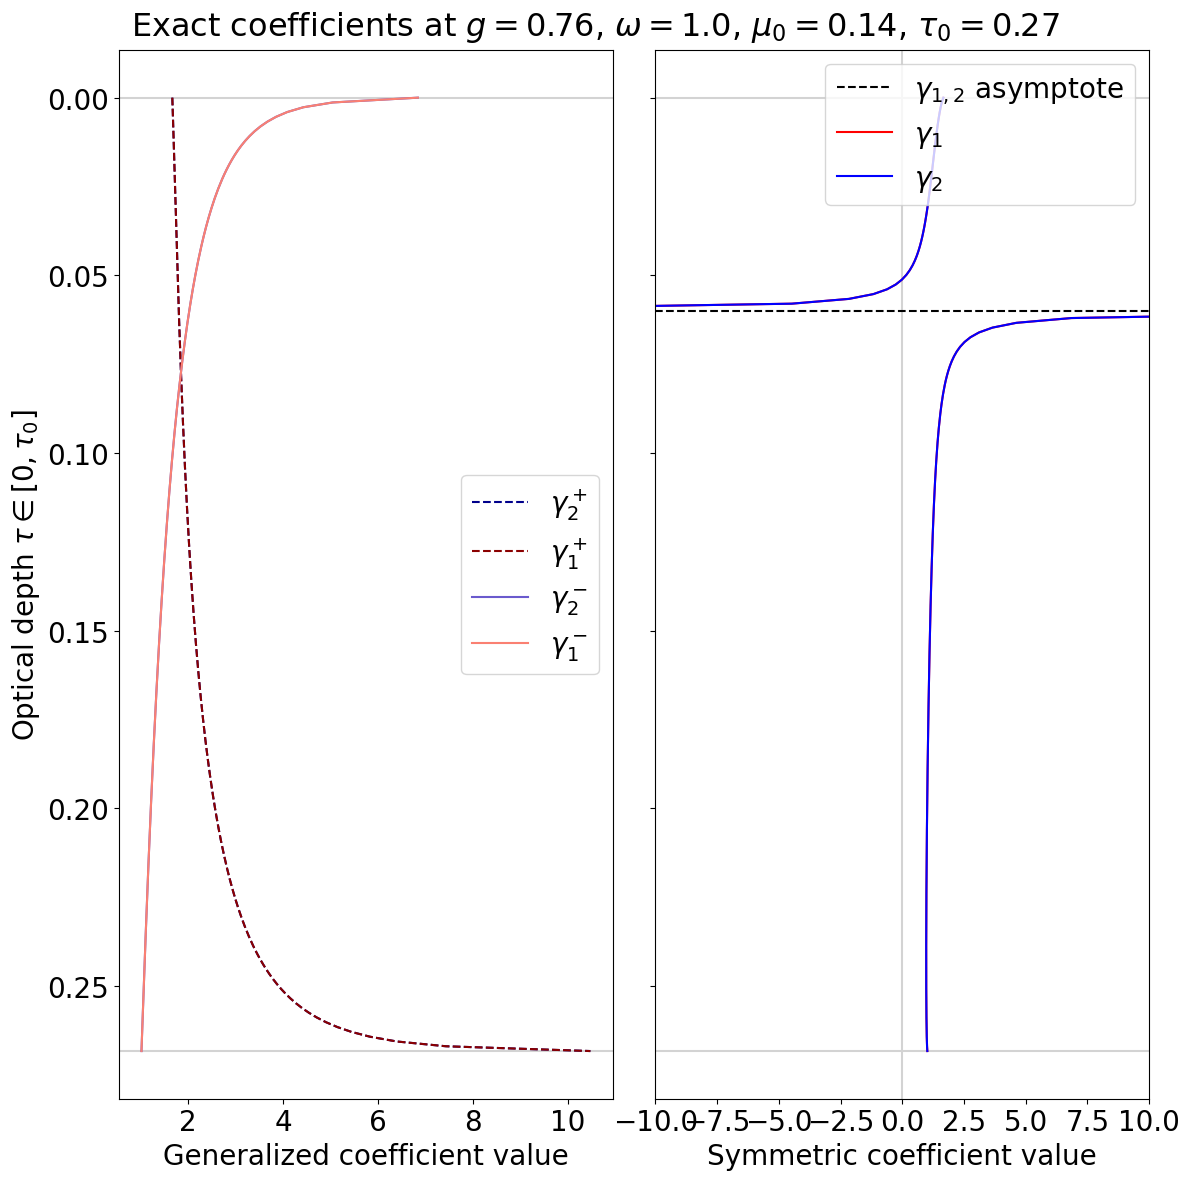

In [16]:
# Plot exact coupling coefficients (Fig. 1)
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(121)
plt.suptitle(
    "Exact coefficients at"
    + " $g =$"
    + str(np.round(g, 2))
    + r", $\omega =$"
    + str(np.round(omega, 2))
    + r", $\mu_0 =$"
    + str(np.round(mu0, 2))
    + r", $\tau_0 =$"
    + str(np.round(tau0, 2)),
    fontsize=23,
)
plt.axhline(tau0, color="lightgrey")
plt.axhline(0, color="lightgrey")
plt.plot(gamma2p_tau, tau_arr, '--', label="$\gamma_2^+$", color="darkblue")
plt.plot(gamma1p_tau, tau_arr, '--', label="$\gamma_1^+$", color="darkred")
plt.plot(gamma2m_tau, tau_arr, label="$\gamma_2^-$", color="slateblue")
plt.plot(gamma1m_tau, tau_arr, label="$\gamma_1^-$", color="salmon")
plt.yticks(fontsize=20)
plt.ylabel(r"Optical depth $\tau \in [0, \tau_0]$", fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel("Generalized coefficient value", fontsize=20)
plt.gca().invert_yaxis()
plt.legend(fontsize=20)

ax2 = plt.subplot(122)
plt.axvline(0, color="lightgrey")
plt.axhline(tau0, color="lightgrey")
plt.axhline(0, color="lightgrey")
try:
    plt.axhline(
        discontinuity,
        linestyle='--',
        color="black",
        label="$\gamma_{1,2}$ asymptote",
    )
except:
    None
plt.plot(gamma1_tau[F_tau < 0], tau_arr[F_tau < 0], label="$\gamma_1$", color="red")
plt.plot(gamma2_tau[F_tau < 0], tau_arr[F_tau < 0], label="$\gamma_2$", color="blue")
plt.plot(gamma1_tau[F_tau > 0], tau_arr[F_tau > 0], color="red")
plt.plot(gamma2_tau[F_tau > 0], tau_arr[F_tau > 0], color="blue")
plt.xlim([-10, 10])
plt.gca().invert_yaxis()
plt.xticks(fontsize=20)
plt.xlabel("Symmetric coefficient value", fontsize=20)
ax2.tick_params(labelleft=False)
plt.legend(fontsize=20)
fig.tight_layout(w_pad=0)

# Baseline two-stream closures

In [17]:
# Baseline two-stream closures
# Zdunkowski
def generate_Zdun_gammas(omega, g, mu0):
    g1 = (8 - omega * (5 + 3 * g)) / 4
    g2 = 3 * omega * (1 - g) / 4
    g3 = (2 - 3 * mu0 * g) / 4
    g4 = 1 - g3
    return g1, g2, g3, g4


# Eddington
def generate_Edd_gammas(omega, g, mu0):
    g1 = (7 - omega * (4 + 3 * g)) / 4
    g2 = -(1 - omega * (4 - 3 * g)) / 4
    g3 = (2 - 3 * mu0 * g) / 4
    g4 = 1 - g3
    return g1, g2, g3, g4


# Coakley-Chylek (I)
def generate_CC1_gammas(omega, g, mu0, beta):
    g1 = (1 - omega * (1 - beta(mu0))) / mu0
    g2 = omega * beta(mu0) / mu0
    g3 = beta(mu0)
    g4 = 1 - g3
    return g1, g2, g3, g4

In [18]:
# Delta-Eddington scaling
f = Leg_coeffs_all[2]
g_scaled = (g - f) / (1 - f)
scale_tau = 1 - omega * f
omega_scaled = ((1 - f) / scale_tau) * omega
tau0_scaled = scale_tau * tau0

T_DSreclass = np.exp(-tau0_scaled / mu0) - np.exp (-tau0 / mu0)
Fm_DSreclass = (
    lambda tau: I0 * mu0 * (np.exp(-tau * scale_tau / mu0) - np.exp(-tau / mu0))
)

In [19]:
# Compute coefficients for baseline two-stream methods
(
    gamma1_Zdun,
    gamma2_Zdun,
    gamma3_Zdun,
    gamma4_Zdun,
) = generate_Zdun_gammas(omega_scaled, g_scaled, mu0)

(
    gamma1_Edd,
    gamma2_Edd,
    gamma3_Edd,
    gamma4_Edd,
) = generate_Edd_gammas(omega_scaled, g_scaled, mu0)

(
    gamma1_CC1,
    gamma2_CC1,
    gamma3_CC1,
    gamma4_CC1,
) = generate_CC1_gammas(omega, g, mu0, beta)

In [20]:
# Calculate R, T from baseline methods
R_true = flux_up(0)
T_true = flux_down(tau0)[0]

R_Zdun, T_Zdun, A_Zdun = RTA_constcoeffs_diffusefluxes(
    gamma1_Zdun,
    gamma1_Zdun,
    gamma2_Zdun,
    gamma2_Zdun,
    gamma3_Zdun,
    omega_scaled,
    tau0_scaled,
    mu0,
)
T_Zdun += T_DSreclass

R_Edd, T_Edd, A_Edd = RTA_constcoeffs_diffusefluxes(
    gamma1_Edd,
    gamma1_Edd,
    gamma2_Edd,
    gamma2_Edd,
    gamma3_Edd,
    omega_scaled,
    tau0_scaled,
    mu0,
)
T_Edd += T_DSreclass

R_CC1, T_CC1, A_CC1 = RTA_constcoeffs_diffusefluxes(
    gamma1_CC1,
    gamma1_CC1,
    gamma2_CC1,
    gamma2_CC1,
    gamma3_CC1,
    omega,
    tau0,
    mu0,
)

In [21]:
# Print R, T errors
print("REFLECTANCE")
print("True:", R_true)
print("Zdunkowski:", R_Zdun)
print(
    "( Error =",
    np.abs(R_Zdun - R_true),
    "|",
    "Error ratio = ",
    np.abs(R_Zdun - R_true) / R_true,
    ")",
)
print("Eddington:", R_Edd)
print(
    "( Error =",
    np.abs(R_Edd - R_true),
    "|",
    "Error ratio = ",
    np.abs(R_Edd - R_true) / R_true,
    ")",
)
print("Coakley-Chylek (I):", R_CC1)
print(
    "( Error =",
    np.abs(R_CC1 - R_true),
    "|",
    "Error ratio = ",
    np.abs(R_CC1 - R_true) / R_true,
    ")",
)
print()
print("TRANSMITTANCE")
print("True:", T_true)
print("Zdunkowski:", T_Zdun)
print(
    "( Error =",
    np.abs(T_Zdun - T_true),
    "|",
    "Error ratio = ",
    np.abs(T_Zdun - T_true) / T_true,
    ")",
)
print("Eddington:", T_Edd)
print(
    "( Error =",
    np.abs(T_Edd - T_true),
    "|",
    "Error ratio = ",
    np.abs(T_Edd - T_true) / T_true,
    ")",
)
print("Coakley-Chylek (I):", T_CC1)
print(
    "( Error =",
    np.abs(T_CC1 - T_true),
    "|",
    "Error ratio = ",
    np.abs(T_CC1 - T_true) / T_true,
    ")",
)

REFLECTANCE
True: 0.3491830242504491
Zdunkowski: 0.25567846304591274
( Error = 0.09350456120453637 | Error ratio =  0.2677809478431886 )
Eddington: 0.2556784479024018
( Error = 0.09350457634804732 | Error ratio =  0.267780991211594 )
Coakley-Chylek (I): 0.3947893877454882
( Error = 0.045606363495039104 | Error ratio =  0.13060876482451292 )

TRANSMITTANCE
True: 0.5044351675049403
Zdunkowski: 0.597939931557854
( Error = 0.09350476405291364 | Error ratio =  0.18536527600843347 )
Eddington: 0.597939946701408
( Error = 0.09350477919646771 | Error ratio =  0.18536530602924695 )
Coakley-Chylek (I): 0.4588272064273871
( Error = 0.045607961077553216 | Error ratio =  0.09041392039167559 )


## Figure 3

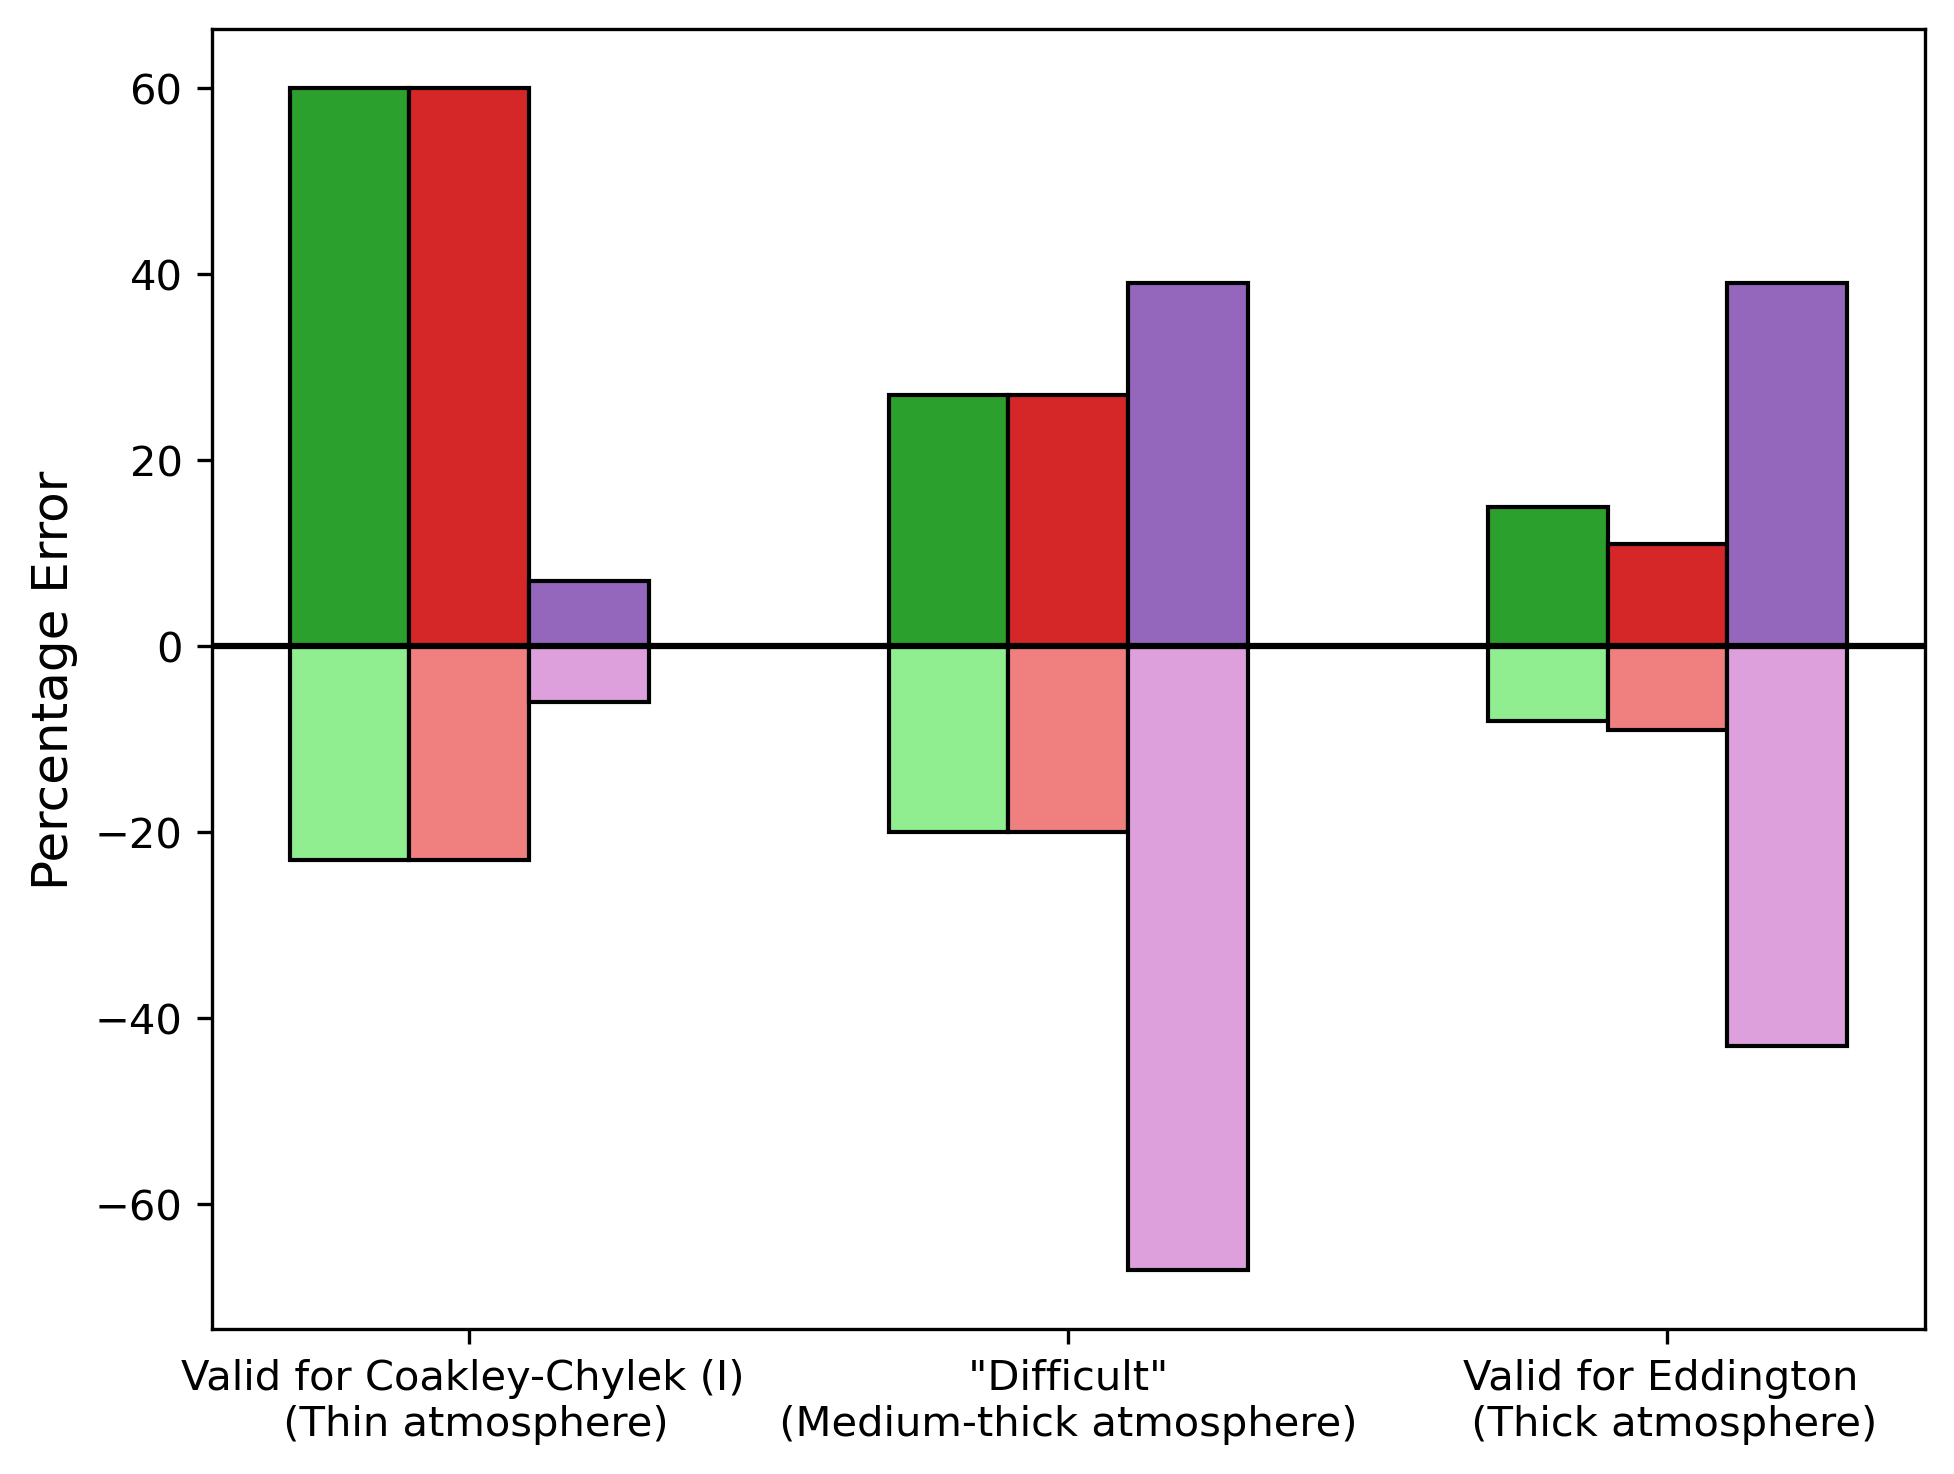

In [22]:
# Bar chart of errors of baseline two-stream closures (Fig. 3); data must be manually keyed
baseline_methods = (
    "Valid for Coakley-Chylek (I) \n (Thin atmosphere)",
    """ "Difficult" \n (Medium-thick atmosphere) """,
    "Valid for Eddington \n (Thick atmosphere)",
)
R = {
    "Zdun": (60, 27, 15),
    "Edd": (60, 27, 11),
    "CC(I)": (7, 39, 39),
}

T = {
    "Zdun": (-23, -20, -8),
    "Edd": (-23, -20, -9),
    "CC(I)": (-6, -67, -43),
}

x = np.arange(len(baseline_methods))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="constrained", dpi=300)

for attribute, measurement in R.items():
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        measurement,
        width,
        label=attribute,
        edgecolor="black",
        color=colors[multiplier + 2],
    )
    multiplier += 1

multiplier = 0
bottom_index = 0
for attribute, measurement in T.items():
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        measurement,
        width,
        label=attribute,
        edgecolor="black",
        color=["lightgreen", "lightcoral", "plum"][multiplier],
    )
    multiplier += 1

ax.set_ylabel("Percentage Error", fontsize=12)
ax.set_xticks(x + width, baseline_methods)
plt.axhline(0, color="black")

**Worst-case reflectance and transmittance errors over all problem parameters**

In [23]:
# R, T error over all problem parameters
clip_min=0

print("Worst case error / error ratios")
print("-------------------------------")
print("Coakley-Chylek")
print(
    "Transmittivity:",
    np.max(np.abs((T_CC1_data - T_true_data))),
    "/",
    np.max(np.abs((T_CC1_data - T_true_data) / T_true_data.clip(min=clip_min))),
)
print(
    "Reflectivity:",
    np.max(np.abs((R_CC1_data - R_true_data))),
    "/",
    np.max(np.abs((R_CC1_data - R_true_data) / R_true_data.clip(min=clip_min))),
)

print()
print("Eddington")
print(
    "Transmittivity:",
    np.max(np.abs((T_Edd_data - T_true_data))),
    "/",
    np.max(np.abs((T_Edd_data - T_true_data) / T_true_data.clip(min=clip_min))),
)
print(
    "Reflectivity:",
    np.max(np.abs((R_Edd_data - R_true_data))),
    "/",
    np.max(np.abs((R_Edd_data - R_true_data) / R_true_data.clip(min=clip_min))),
)

print()
print("Zdunkowski")
print(
    "Transmittivity:",
    np.max(np.abs((T_Zdun_data - T_true_data))),
    "/",
    np.max(np.abs((T_Zdun_data - T_true_data) / T_true_data.clip(min=clip_min))),
)
print(
    "Reflectivity:",
    np.max(np.abs((R_Zdun_data - R_true_data))),
    "/",
    np.max(np.abs((R_Zdun_data - R_true_data) / R_true_data.clip(min=clip_min))),
)

print()
print("Symmetric optimized")
print(
    "Transmittivity:",
    np.max(np.abs((T_opt2_data - T_true_data))),
    "/",
    np.max(np.abs((T_opt2_data - T_true_data) / T_true_data.clip(min=clip_min))),
)
print(
    "Reflectivity:",
    np.max(np.abs((R_opt2_data - R_true_data))),
    "/",
    np.max(np.abs((R_opt2_data - R_true_data) / R_true_data.clip(min=clip_min))),
)

print()
print("General optimized")
print(
    "Transmittivity:",
    np.max(np.abs((T_opt4_data - T_true_data))),
    "/",
    np.max(np.abs((T_opt4_data - T_true_data) / T_true_data.clip(min=clip_min))),
)
print(
    "Reflectivity:",
    np.max(np.abs((R_opt4_data - R_true_data))),
    "/",
    np.max(np.abs((R_opt4_data - R_true_data) / R_true_data.clip(min=clip_min))),
)

Worst case error / error ratios
-------------------------------
Coakley-Chylek
Transmittivity: 0.3779473611659255 / 4.666505956696707
Reflectivity: 0.325971509736775 / 0.6560467388165083

Eddington
Transmittivity: 0.33320366367194 / 1.065051942546076
Reflectivity: 0.3332053140883341 / 0.8475753857531522

Zdunkowski
Transmittivity: 0.33320366357601894 / 1.0650482922228734
Reflectivity: 0.3332053139924096 / 0.8475695751006483

Symmetric optimized
Transmittivity: 9.167340251914347e-06 / 2.3940078703502484e-05
Reflectivity: 9.167324985792646e-06 / 2.264628939597395e-05

General optimized
Transmittivity: 9.189260366138097e-06 / 3.279568694295068e-05
Reflectivity: 9.174785234433713e-06 / 2.264705848159928e-05


# Numerical Optimization (for one set of problem parameters)

In [24]:
# Vertically-integrated flux formulas, i.e. equation (12) integrated from tau = 0 to tau = tau0
def gen_constcoeffs_indefint_diffusefluxes(
    g1p, g1m, g2p, g2m, g3, incident_flux, omega, tau0, mu0, g4=None
):
    if g4 == None:
        g4 = 1 - g3

    k = np.sqrt(g1p**2 + 2 * g1p * g1m + g1m**2 - 4 * g2p * g2m + 0j)
    lp = (g1p - g1m + k) / 2
    lm = (g1p - g1m - k) / 2
    a1 = 2 * g2m * ((g1p * g4 + g2p * g3) * mu0 + g4)
    a2 = 2 * g2p * ((g1m * g3 + g2m * g4) * mu0 - g3)
    a3 = g1p + g1m + k
    a4 = g1p + g1m - k
    a5 = (g1m * g3 + g2m * g4) * mu0 - g3
    a6 = (g1p * g4 + g2p * g3) * mu0 + g4
    a7 = (g1p * g1m - g2p * g2m) * mu0**2 + (g1m - g1p) * mu0 - 1
    
    if np.abs(lp) < 1e-15:
        lp_reciprocal = 0
    else:
        lp_reciprocal = 1 / lp
    if np.abs(lm) < 1e-15:
        lm_reciprocal = 0
    else:
        lm_reciprocal = 1 / lm

    if np.real(lp) >= 0 and np.real(lm) >= 0:
        denom = a7 * (a3 * np.exp(-lm * tau0) - a4 * np.exp(-lp * tau0))
        if np.abs(denom) < 1e-15:
            denom_reciprocal = 0
        else:
            denom_reciprocal = 1 / denom
        IntFpC = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a1 * (np.exp(lp * (tau - tau0)) * lp_reciprocal - np.exp(lm * (tau - tau0)) * lm_reciprocal)
                - a5
                * (
                    a3
                    * (
                        np.exp(lp * (tau - tau0) - tau0 / mu0 - lm * tau0) * lp_reciprocal
                        + mu0 * np.exp(-tau / mu0 - lm * tau0)
                    )
                    - a4
                    * (
                        np.exp(lm * (tau - tau0) - tau0 / mu0 - lp * tau0) * lm_reciprocal
                        + mu0 * np.exp(-tau / mu0 - lp * tau0)
                    )
                )
            )
            * denom_reciprocal
        )
        IntFmC = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a2
                * (
                    np.exp(lm * (tau - tau0) - tau0 / mu0 - lp * tau0) * lm_reciprocal
                    - np.exp(lp * (tau - tau0) - tau0 / mu0 - lm * tau0) * lp_reciprocal
                )
                + a6
                * (
                    a3
                    * (
                        -mu0 * np.exp(-tau / mu0 - lm * tau0)
                        - np.exp(lm * (tau - tau0)) * lm_reciprocal
                    )
                    - a4
                    * (
                        -mu0 * np.exp(-tau / mu0 - lp * tau0)
                        - np.exp(lp * (tau - tau0)) * lp_reciprocal
                    )
                )
            )
            * denom_reciprocal
        )

    elif np.real(lp) >= 0 and np.real(lm) <= 0:
        denom = a7 * (a3 - a4 * np.exp(-k * tau0))  # lm - lp = -k
        if np.abs(denom) < 1e-15:
            denom_reciprocal = 0
        else:
            denom_reciprocal = 1 / denom
        IntFpC = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a1 * (np.exp(lp * tau - k * tau0) * lp_reciprocal - np.exp(lm * tau) * lm_reciprocal)
                - a5
                * (
                    a3
                    * (
                        np.exp(lp * (tau - tau0) - tau0 / mu0) * lp_reciprocal
                        + mu0 * np.exp(-tau / mu0)
                    )
                    - a4
                    * (
                        np.exp(lm * tau - tau0 / mu0 - lp * tau0) * lm_reciprocal
                        + mu0 * np.exp(-k * tau0 - tau / mu0)
                    )
                )
            )
            * denom_reciprocal
        )
        IntFmC = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a2
                * (
                    np.exp(lm * tau - tau0 / mu0 - lp * tau0) * lm_reciprocal
                    - np.exp(lp * (tau - tau0) - tau0 / mu0) * lp_reciprocal
                )
                + a6
                * (
                    a3 * (-mu0 * np.exp(-tau / mu0) - np.exp(lm * tau) * lm_reciprocal)
                    - a4
                    * (
                        -mu0 * np.exp(-k * tau0 - tau / mu0)
                        - np.exp(lp * tau - k * tau0) * lp_reciprocal
                    )
                )
            )
            * denom_reciprocal
        )

    elif np.real(lp) <= 0 and np.real(lm) >= 0:
        denom = a7 * (a3 * np.exp(k * tau0) - a4)  # lp - lm = k
        if np.abs(denom) < 1e-15:
            denom_reciprocal = 0
        else:
            denom_reciprocal = 1 / denom
        IntFpC = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a1 * (np.exp(lp * tau) * lp_reciprocal - np.exp(k * tau0 + lm * tau) * lm_reciprocal)
                - a5
                * (
                    a3
                    * (
                        np.exp(lp * tau - tau0 / mu0 - lm * tau0) * lp_reciprocal
                        + mu0 * np.exp(k * tau0 - tau / mu0)
                    )
                    - a4
                    * (
                        np.exp(lm * (tau - tau0) - tau0 / mu0) * lm_reciprocal
                        + mu0 * np.exp(-tau / mu0)
                    )
                )
            )
            * denom_reciprocal
        )
        IntFmC = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a2
                * (
                    np.exp(lm * (tau - tau0) - tau0 / mu0) * lm_reciprocal
                    - np.exp(lp * tau - tau0 / mu0 - lm * tau0) * lp_reciprocal
                )
                + a6
                * (
                    a3
                    * (
                        -mu0 * np.exp(k * tau0 - tau / mu0)
                        - np.exp(k * tau0 + lm * tau) * lm_reciprocal
                    )
                    - a4 * (-mu0 * np.exp(-tau / mu0) - np.exp(lp * tau) * lp_reciprocal)
                )
            )
            * denom_reciprocal
        )

    else:
        denom = a7 * (a3 * np.exp(lp * tau0) - a4 * np.exp(lm * tau0))
        if np.abs(denom) < 1e-15:
            denom_reciprocal = 0
        else:
            denom_reciprocal = 1 / denom
        IntFpC = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a1
                * (
                    np.exp(lp * tau + lm * tau0) * lp_reciprocal
                    - np.exp(lp * tau0 + lm * tau) * lm_reciprocal
                )
                - a5
                * (
                    a3
                    * (
                        np.exp(lp * tau - tau0 / mu0) * lp_reciprocal
                        + mu0 * np.exp(lp * tau0 - tau / mu0)
                    )
                    - a4
                    * (
                        np.exp(lm * tau - tau0 / mu0) * lm_reciprocal
                        + mu0 * np.exp(lm * tau0 - tau / mu0)
                    )
                )
            )
            * denom_reciprocal
        )
        IntFmC = lambda tau: np.real(
            omega
            * incident_flux
            * (
                a2
                * (
                    np.exp(lm * tau - tau0 / mu0) * lm_reciprocal
                    - np.exp(lp * tau - tau0 / mu0) * lp_reciprocal
                )
                + a6
                * (
                    a3
                    * (
                        -mu0 * np.exp(lp * tau0 - tau / mu0)
                        - np.exp(lp * tau0 + lm * tau) * lm_reciprocal
                    )
                    - a4
                    * (
                        -mu0 * np.exp(lm * tau0 - tau / mu0)
                        - np.exp(lp * tau + lm * tau0) * lp_reciprocal
                    )
                )
            )
            * denom_reciprocal
        )
        
    return IntFpC, IntFmC

In [25]:
# Vertically-integrated D terms (of equation (6))
intu0 = (u0(tau0, is_antiderivative_wrt_tau=True) - u0(0, is_antiderivative_wrt_tau=True))

dFtrue1p = (
    -(2 * pi)
    * (1 - omega / 2 * (1 + S_cache))
    * weights_mu
    @ atleast_2d_append(intu0)[:N, :]
)[0]
dFtrue2m = (
    -(2 * pi)
    * (omega / 2)
    * (1 - S_cache)
    * weights_mu
    @ atleast_2d_append(intu0)[N:, :]
)[0]
dFtrue2p = (
    (2 * pi)
    * (omega / 2)
    * (1 - S_cache)
    * weights_mu
    @ atleast_2d_append(intu0)[:N, :]
)[0]
dFtrue1m = (
    (2 * pi)
    * (1 - omega / 2 * (1 + S_cache))
    * weights_mu
    @ atleast_2d_append(intu0)[N:, :]
)[0]

**Optimize general coupling coefficients**

In [26]:
# Objective function and acceptance test
tau_check = np.linspace(0, tau0, 51)[1:-1]


def to_min4(gamma_arr):
    intFpC, intFmC = gen_constcoeffs_indefint_diffusefluxes(
        gamma_arr[0],
        gamma_arr[1],
        gamma_arr[2],
        gamma_arr[3],
        beta0,
        I0 * mu0,
        omega,
        tau0,
        mu0,
    )
    intFp = intFpC(tau0) - intFpC(0)
    intFm = intFmC(tau0) - intFmC(0)
    dF1p = gamma_arr[0] * -intFp
    dF1m = gamma_arr[1] * intFm
    dF2p = gamma_arr[2] * intFp
    dF2m = gamma_arr[3] * -intFm
    return np.sum(
        np.array(
            [
                (dF1p - dFtrue1p) / dFtrue1p,
                (dF1m - dFtrue1m) / dFtrue1m,
                (dF2p - dFtrue2p) / dFtrue2p,
                (dF2m - dFtrue2m) / dFtrue2m,
            ]
        )
        ** 2
    )


jac4 = ag.grad(to_min4)


def accept_test4(f_new, x_new, f_old, x_old):
    Fp, Fm = gen_constcoeffs_diffusefluxes(
        x_new[0],
        x_new[1],
        x_new[2],
        x_new[3],
        beta0,
        I0 * mu0,
        omega,
        tau0,
        mu0,
    )
    return (
        np.all(x_new > 0)
        and np.all(Fp(tau_check) > 0)
        and np.all(Fm(tau_check) > 0)
    )

In [27]:
# Optimization
IC = np.random.random(4)
print("Initial condition =", IC)

opt4 = sc.optimize.basinhopping(
    to_min4,
    IC,
    accept_test=accept_test4,
    minimizer_kwargs={"jac": jac4},
    T=0,
    stepsize=0.3,
    niter=1000,
    niter_success=50,
    interval=20,
    target_accept_rate=0.3,
    disp=True,
)

Initial condition = [0.84414939 0.79295345 0.86994523 0.67922527]
basinhopping step 0: f 3.68537e-11
basinhopping step 1: f 3.68537e-11 trial_f 4.86519e-11 accepted 0  lowest_f 3.68537e-11
basinhopping step 2: f 1.99401e-11 trial_f 1.99401e-11 accepted 1  lowest_f 1.99401e-11
found new global minimum on step 2 with function value 1.99401e-11
basinhopping step 3: f 2.86059e-12 trial_f 2.86059e-12 accepted 1  lowest_f 2.86059e-12
found new global minimum on step 3 with function value 2.86059e-12
basinhopping step 4: f 2.86059e-12 trial_f 1.03979e-11 accepted 0  lowest_f 2.86059e-12
basinhopping step 5: f 2.86059e-12 trial_f 3.13125e-11 accepted 0  lowest_f 2.86059e-12
basinhopping step 6: f 5.27802e-13 trial_f 5.27802e-13 accepted 1  lowest_f 5.27802e-13
found new global minimum on step 6 with function value 5.27802e-13
basinhopping step 7: f 5.27802e-13 trial_f 7.80468e-12 accepted 0  lowest_f 5.27802e-13
basinhopping step 8: f 5.27802e-13 trial_f 2.2295e-12 accepted 0  lowest_f 5.27802

In [28]:
# Result
gamma1p_opt, gamma1m_opt, gamma2p_opt, gamma2m_opt = opt4["x"]
opt4

                    message: ['success condition satisfied']
                    success: True
                        fun: 2.3515635480571387e-13
                          x: [ 1.818e+00  1.397e+00  1.818e+00  1.397e+00]
                        nit: 60
      minimization_failures: 0
                       nfev: 587
                       njev: 587
 lowest_optimization_result:  message: Optimization terminated successfully.
                              success: True
                               status: 0
                                  fun: 2.3515635480571387e-13
                                    x: [ 1.818e+00  1.397e+00  1.818e+00
                                         1.397e+00]
                                  nit: 9
                                  jac: [-1.776e-07  2.145e-07 -2.679e-07
                                         9.823e-08]
                             hess_inv: [[ 2.605e+00  1.687e-02  6.567e-01
                                         -6.507e-01]
       

**Optimized symmetric coupling coefficients**

In [29]:
# Objective function
tau_check = np.linspace(0, tau0, 51)[1:-1]


def to_min2(gamma_arr):
    intFpC, intFmC = gen_constcoeffs_indefint_diffusefluxes(
        gamma_arr[0],
        gamma_arr[0],
        gamma_arr[1],
        gamma_arr[1],
        beta0,
        I0 * mu0,
        omega,
        tau0,
        mu0,
    )
    intFp = intFpC(tau0) - intFpC(0)
    intFm = intFmC(tau0) - intFmC(0)
    dF1p = gamma_arr[0] * -intFp
    dF1m = gamma_arr[0] * intFm
    dF2p = gamma_arr[1] * intFp
    dF2m = gamma_arr[1] * -intFm
    return np.sum(
        np.array(
            [
                ((dF1p - dF2m) - (dFtrue1p - dFtrue2m)) / (dFtrue1p - dFtrue2m),
                ((dF2p - dF1m) - (dFtrue2p - dFtrue1m)) / (dFtrue2p - dFtrue1m),
            ]
        )
        ** 2
    )


jac2 = ag.grad(to_min2)


def accept_test2(f_new, x_new, f_old, x_old):
    Fp, Fm = gen_constcoeffs_diffusefluxes(
        x_new[0],
        x_new[0],
        x_new[1],
        x_new[1],
        beta0,
        I0 * mu0,
        omega,
        tau0,
        mu0,
    )
    return (
        np.all(x_new > 0)
        and np.all(Fp(tau_check) > 0)
        and np.all(Fm(tau_check) > 0)
    )

In [30]:
# Optimization
IC = np.random.random(2)
print("Initial condition =", IC)

opt2 = sc.optimize.basinhopping(
    to_min2,
    IC,
    accept_test=accept_test2,
    minimizer_kwargs={"jac": jac2},
    T=0,
    stepsize=0.3,
    niter=1000,
    niter_success=50,
    interval=20,
    target_accept_rate=0.3,
    disp=True,
)

Initial condition = [0.23468272 0.22032951]
basinhopping step 0: f 7.14427e-13
basinhopping step 1: f 1.36236e-13 trial_f 1.36236e-13 accepted 1  lowest_f 1.36236e-13
found new global minimum on step 1 with function value 1.36236e-13
basinhopping step 2: f 3.08582e-15 trial_f 3.08582e-15 accepted 1  lowest_f 3.08582e-15
found new global minimum on step 2 with function value 3.08582e-15
basinhopping step 3: f 7.56717e-17 trial_f 7.56717e-17 accepted 1  lowest_f 7.56717e-17
found new global minimum on step 3 with function value 7.56717e-17
basinhopping step 4: f 7.56717e-17 trial_f 2.30395e-13 accepted 0  lowest_f 7.56717e-17
basinhopping step 5: f 7.56717e-17 trial_f 2.71533e-14 accepted 0  lowest_f 7.56717e-17
basinhopping step 6: f 7.56717e-17 trial_f 3.01339e-12 accepted 0  lowest_f 7.56717e-17
basinhopping step 7: f 7.56717e-17 trial_f 1.33494e-13 accepted 0  lowest_f 7.56717e-17
basinhopping step 8: f 7.56717e-17 trial_f 6.48601e-14 accepted 0  lowest_f 7.56717e-17
basinhopping ste

In [31]:
# Result
gamma1_opt, gamma2_opt = opt2["x"]
opt2

                    message: ['success condition satisfied']
                    success: True
                        fun: 7.567170432657089e-17
                          x: [ 1.072e+00  1.072e+00]
                        nit: 54
      minimization_failures: 0
                       nfev: 366
                       njev: 366
 lowest_optimization_result:  message: Optimization terminated successfully.
                              success: True
                               status: 0
                                  fun: 7.567170432657089e-17
                                    x: [ 1.072e+00  1.072e+00]
                                  nit: 5
                                  jac: [-8.276e-09  2.301e-08]
                             hess_inv: [[ 5.198e-01  4.264e-01]
                                        [ 4.264e-01  5.235e-01]]
                                 nfev: 7
                                 njev: 7

In [32]:
# Calculate R, T from optimized methods
R_opt2, T_opt2, A_opt2 = RTA_constcoeffs_diffusefluxes(
    gamma1_opt,
    gamma1_opt,
    gamma2_opt,
    gamma2_opt,
    beta0,
    omega,
    tau0,
    mu0,
)

R_opt4, T_opt4, A_opt4 = RTA_constcoeffs_diffusefluxes(
    gamma1p_opt,
    gamma1m_opt,
    gamma2p_opt,
    gamma2m_opt,
    beta0,
    omega,
    tau0,
    mu0,
)

In [33]:
# Print R, T errors
print("REFLECTANCE")
print("True:", R_true)
print("Local optimization")
print("Optimized (2 coefficients):", R_opt2)
print(
    "( Error =",
    np.abs(R_opt2 - R_true),
    "|",
    "Error ratio = ",
    np.abs(R_opt2 - R_true) / R_true,
    ")",
)
print("Optimized (4 coefficients):", R_opt4)
print(
    "( Error =",
    np.abs(R_opt4 - R_true),
    "|",
    "Error ratio = ",
    np.abs(R_opt4 - R_true) / R_true,
    ")",
)
print()
print("TRANSMITTANCE")
print("True:", T_true)
print("Optimized (2 coefficients):", T_opt2)
print(
    "( Error =",
    np.abs(T_opt2 - T_true),
    "|",
    "Error ratio = ",
    np.abs(T_opt2 - T_true) / T_true,
    ")",
)
print("Optimized (4 coefficients):", T_opt4)
print(
    "( Error =",
    np.abs(T_opt4 - T_true),
    "|",
    "Error ratio = ",
    np.abs(T_opt4 - T_true) / T_true,
    ")",
)

REFLECTANCE
True: 0.3491830242504491
Local optimization
Optimized (2 coefficients): 0.3491830324083047
( Error = 8.157855613255549e-09 | Error ratio =  2.3362692475578033e-08 )
Optimized (4 coefficients): 0.3491830874900309
( Error = 6.323958179343947e-08 | Error ratio =  1.8110726295812514e-07 )

TRANSMITTANCE
True: 0.5044351675049403
Optimized (2 coefficients): 0.5044351597585769
( Error = 7.7463634395869e-09 | Error ratio =  1.5356509495367478e-08 )
Optimized (4 coefficients): 0.5044351141440149
( Error = 5.3360925456047426e-08 | Error ratio =  1.0578351568940684e-07 )


In [34]:
# Generate data to plot Fig. 4
Fp2, Fm2 = gen_constcoeffs_diffusefluxes(
    gamma1_opt,
    gamma1_opt,
    gamma2_opt,
    gamma2_opt,
    beta0,
    I0 * mu0,
    omega,
    tau0,
    mu0,
)
Fp2_abs_err = np.abs(Fp2(tau_arr) - flux_up(tau_arr))
Fm2_abs_err = np.abs(Fm2(tau_arr) - flux_down(tau_arr)[0])
Fp2_rel_err = np.abs(Fp2(tau_arr) - flux_up(tau_arr)) / flux_up(tau_arr)
Fm2_rel_err = np.abs(Fm2(tau_arr) - flux_down(tau_arr)[0]) / flux_down(tau_arr)[0]

Fp4, Fm4 = gen_constcoeffs_diffusefluxes(
    gamma1p_opt,
    gamma1m_opt,
    gamma2p_opt,
    gamma2m_opt,
    beta0,
    I0 * mu0,
    omega,
    tau0,
    mu0,
)
Fp4_abs_err = np.abs(Fp4(tau_arr) - flux_up(tau_arr))
Fm4_abs_err = np.abs(Fm4(tau_arr) - flux_down(tau_arr)[0])
Fp4_rel_err = np.abs(Fp4(tau_arr) - flux_up(tau_arr)) / flux_up(tau_arr)
Fm4_rel_err = np.abs(Fm4(tau_arr) - flux_down(tau_arr)[0]) / flux_down(tau_arr)[0]

Fp_Zdun, Fm_Zdun = gen_constcoeffs_diffusefluxes(
    gamma1_Zdun,
    gamma1_Zdun,
    gamma2_Zdun,
    gamma2_Zdun,
    gamma3_Zdun,
    I0 * mu0,
    omega_scaled,
    tau0_scaled,
    mu0,
)
Fp_Zdun_abs_err = np.abs(Fp_Zdun(tau_arr * scale_tau) - flux_up(tau_arr))
Fm_Zdun_abs_err = np.abs(
    Fm_Zdun(tau_arr * scale_tau) + Fm_DSreclass(tau_arr) - flux_down(tau_arr)[0]
)
Fp_Zdun_rel_err = np.abs(Fp_Zdun(tau_arr * scale_tau) - flux_up(tau_arr)) / flux_up(
    tau_arr
)
Fm_Zdun_rel_err = (
    np.abs(Fm_Zdun(tau_arr * scale_tau) + Fm_DSreclass(tau_arr) - flux_down(tau_arr)[0])
    / flux_down(tau_arr)[0]
)

Fp_Edd, Fm_Edd = gen_constcoeffs_diffusefluxes(
    gamma1_Edd,
    gamma1_Edd,
    gamma2_Edd,
    gamma2_Edd,
    gamma3_Edd,
    I0 * mu0,
    omega_scaled,
    tau0_scaled,
    mu0,
)
Fp_Edd_abs_err = np.abs(Fp_Edd(tau_arr * scale_tau) - flux_up(tau_arr))
Fm_Edd_abs_err = np.abs(
    Fm_Edd(tau_arr * scale_tau) + Fm_DSreclass(tau_arr) - flux_down(tau_arr)[0]
)
Fp_Edd_rel_err = np.abs(Fp_Edd(tau_arr * scale_tau) - flux_up(tau_arr)) / flux_up(
    tau_arr
)
Fm_Edd_rel_err = (
    np.abs(Fm_Edd(tau_arr * scale_tau) + Fm_DSreclass(tau_arr) - flux_down(tau_arr)[0])
    / flux_down(tau_arr)[0]
)

Fp_CC1, Fm_CC1 = gen_constcoeffs_diffusefluxes(
    gamma1_CC1,
    gamma1_CC1,
    gamma2_CC1,
    gamma2_CC1,
    gamma3_CC1,
    I0 * mu0,
    omega,
    tau0,
    mu0,
)
Fp_CC1_abs_err = np.abs(Fp_CC1(tau_arr) - flux_up(tau_arr))
Fm_CC1_abs_err = np.abs(Fm_CC1(tau_arr) - flux_down(tau_arr)[0])
Fp_CC1_rel_err = np.abs(Fp_CC1(tau_arr) - flux_up(tau_arr)) / flux_up(tau_arr)
Fm_CC1_rel_err = np.abs(Fm_CC1(tau_arr) - flux_down(tau_arr)[0]) / flux_down(tau_arr)[0]

## Figure 4

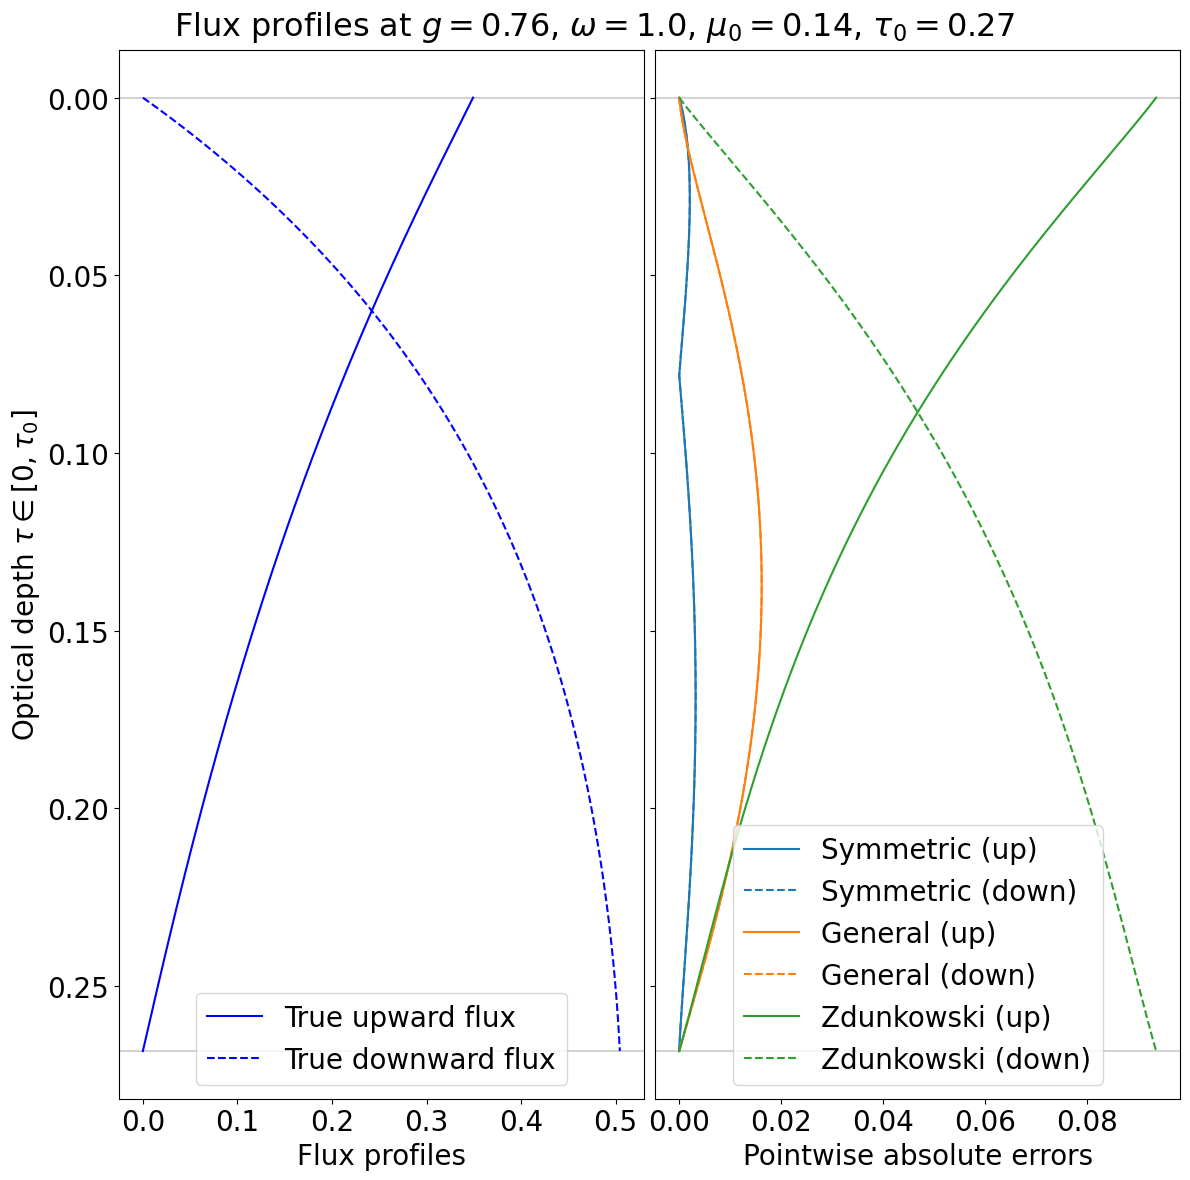

In [35]:
# Plots of flux profiles and errors (Fig. 4)
fig = plt.figure(figsize=(12, 12))
plt.suptitle(
    "Flux profiles at"
    + " $g =$"
    + str(np.round(g, 2))
    + r", $\omega =$"
    + str(np.round(omega, 2))
    + r", $\mu_0 =$"
    + str(np.round(mu0, 2))
    + r", $\tau_0 =$"
    + str(np.round(tau0, 2)),
    fontsize=23,
)

ax1 = plt.subplot(121)
plt.axhline(tau0, color="lightgrey")
plt.axhline(0, color="lightgrey")
plt.plot(flux_up(tau_arr), tau_arr, color="blue", label="True upward flux")
plt.plot(flux_down(tau_arr)[0], tau_arr, '--', color="blue", label="True downward flux")
plt.yticks(fontsize=20)
plt.ylabel(r"Optical depth $\tau \in [0, \tau_0]$", fontsize=20)
plt.xlabel(r"Flux profiles", fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=20)
plt.gca().invert_yaxis()
plt.legend(fontsize=20)

ax2 = plt.subplot(122)
ax2.tick_params(labelleft=False)
plt.axhline(tau0, color="lightgrey")
plt.axhline(0, color="lightgrey")
plt.plot(Fp2_abs_err, tau_arr, color=colors[0], label="Symmetric (up)")
plt.plot(Fm2_abs_err, tau_arr, "--", color=colors[0], label="Symmetric (down)")
plt.plot(Fp4_abs_err, tau_arr, color=colors[1], label="General (up)")
plt.plot(Fm4_abs_err, tau_arr, "--", color=colors[1], label="General (down)")
plt.plot(Fp_Zdun_abs_err, tau_arr, color=colors[2], label="Zdunkowski (up)")
plt.plot(Fm_Zdun_abs_err, tau_arr, "--", color=colors[2], label="Zdunkowski (down)")
plt.locator_params(axis='x', nbins=6)
plt.yticks(fontsize=20)
plt.xlabel(r"Pointwise absolute errors", fontsize=20)
plt.xticks(fontsize=20)
plt.gca().invert_yaxis()
plt.legend(fontsize=20)

#plt.legend(fontsize=20)
fig.tight_layout(w_pad=0)

# Contour and 3D plots of dataset

In [36]:
# Create meshgrids
T, M = np.meshgrid(np.log10(tau0_data), mu0_data)
G, O = np.meshgrid(g_data, omega_data)

## Figure 5

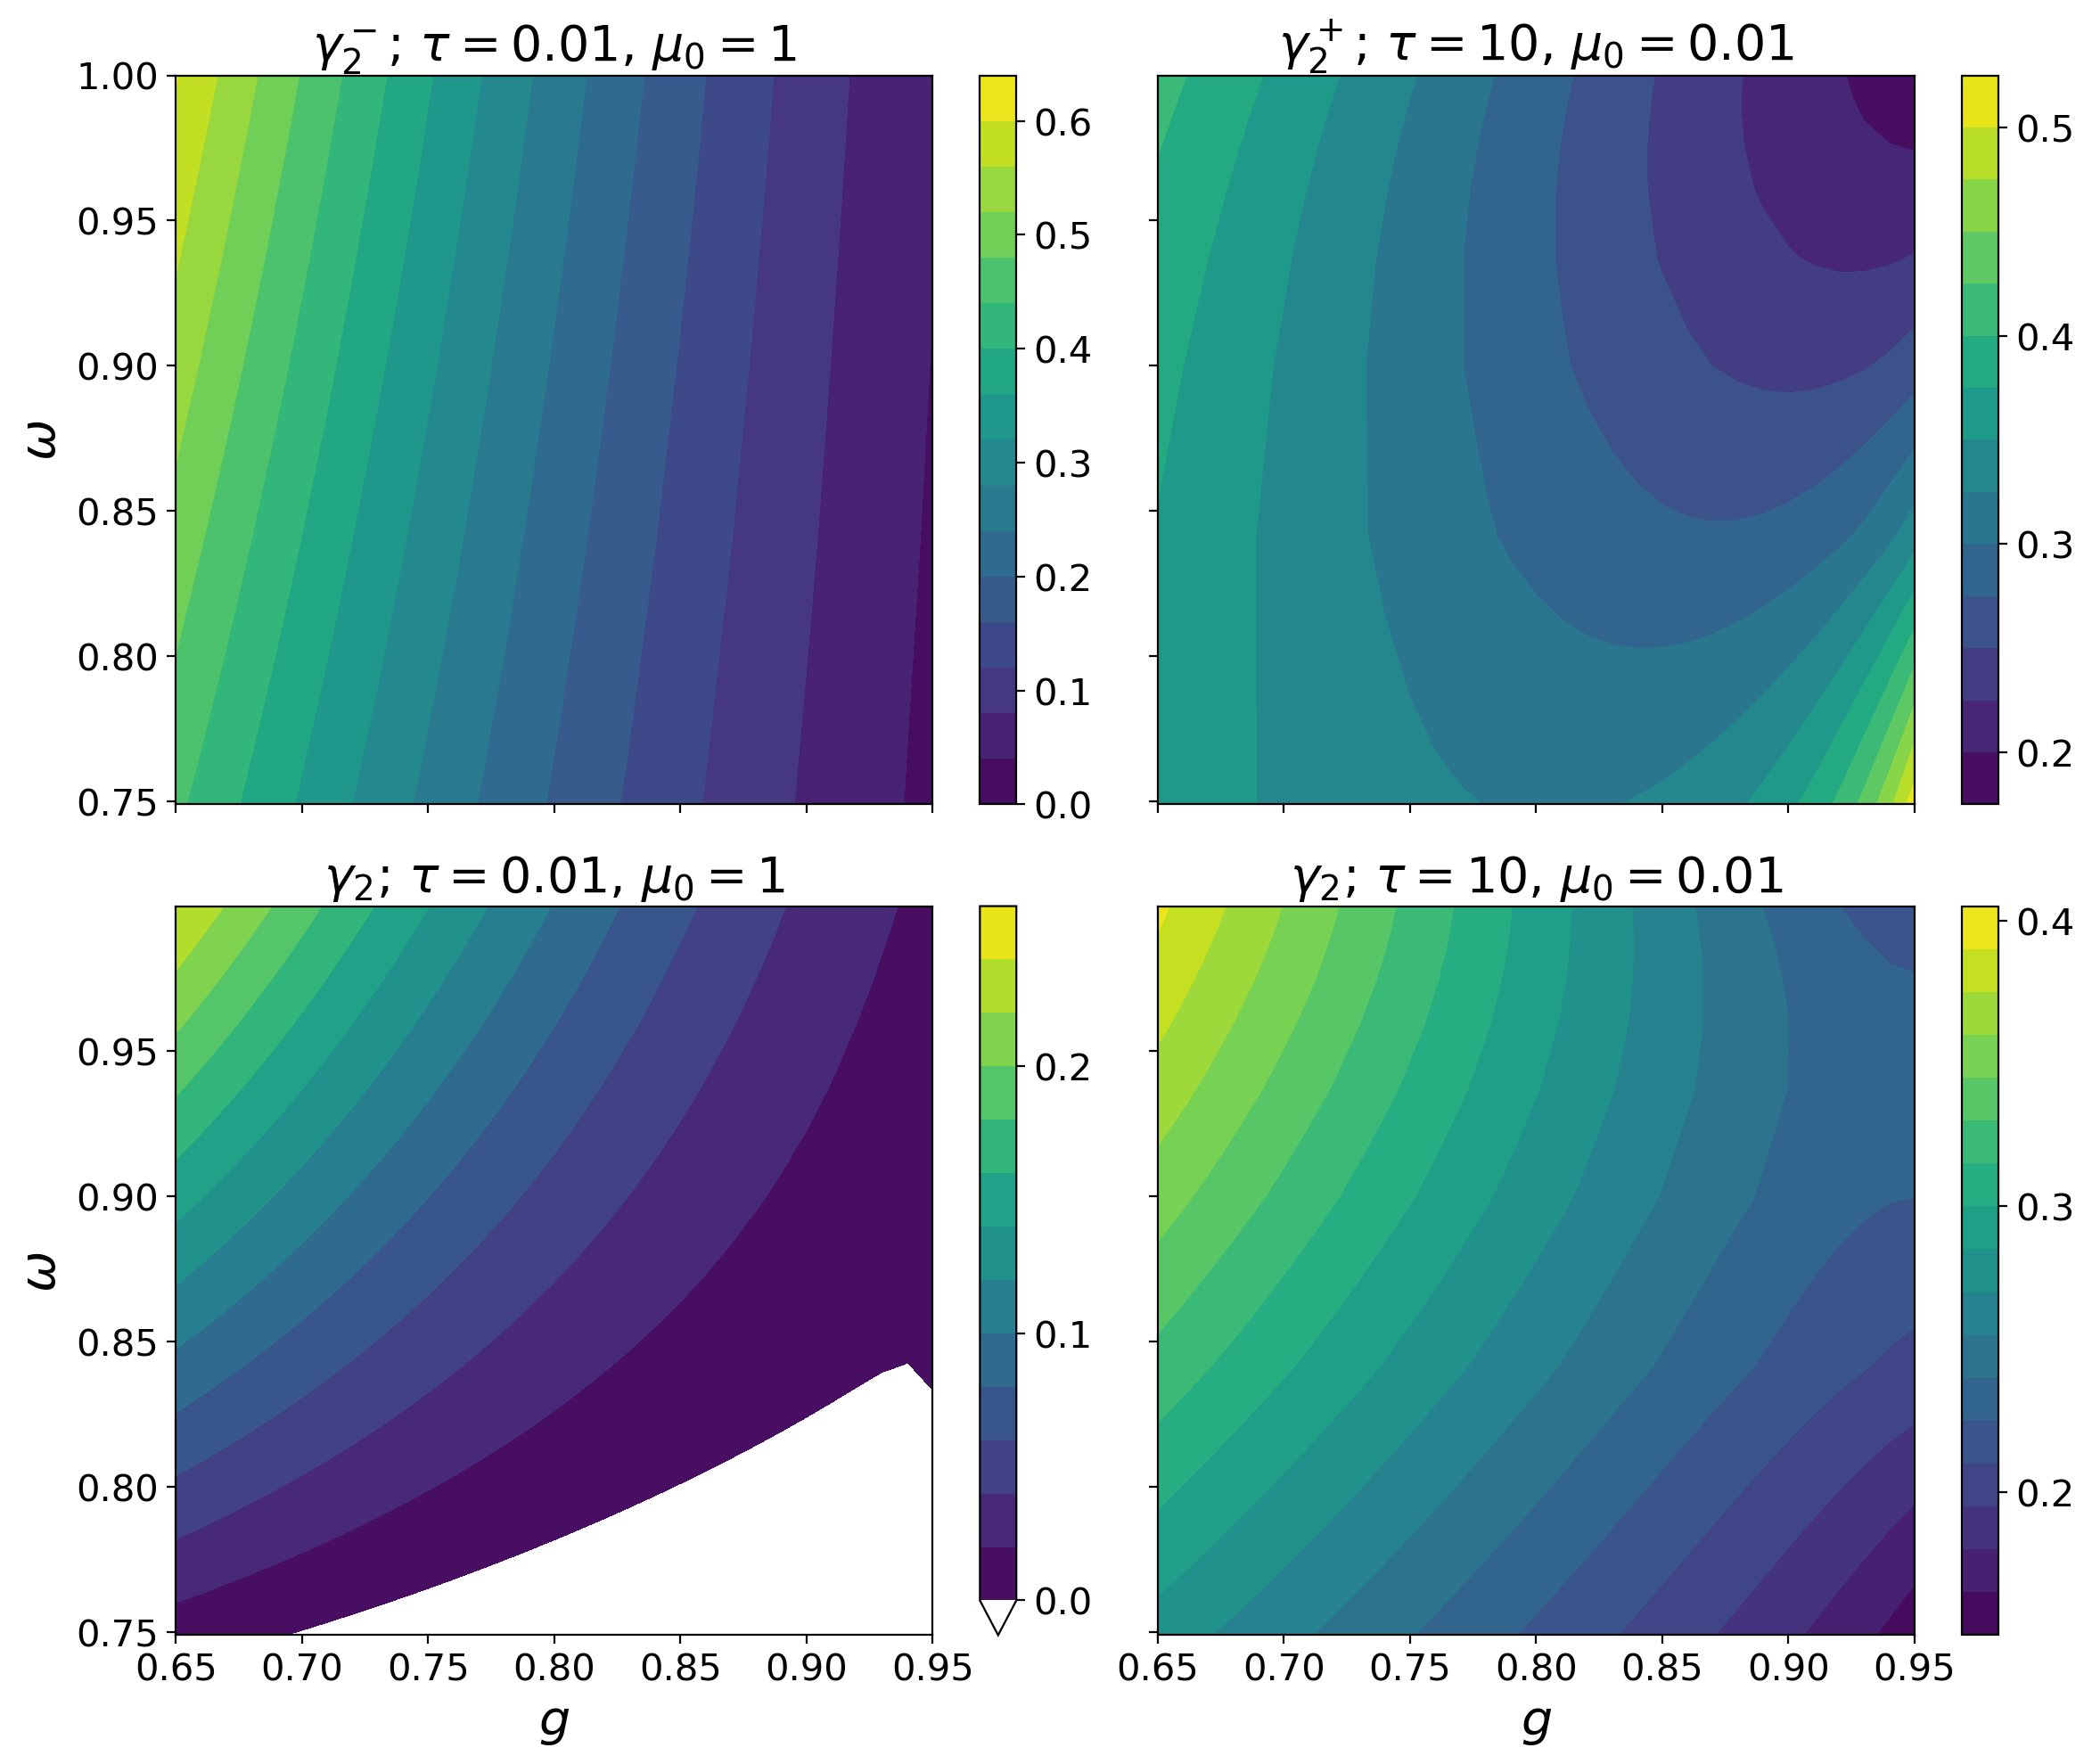

In [37]:
# Variation against single-scattering parameters: g, omega (Fig. 5)
fig = plt.figure(figsize=(12, 10), dpi=200)
ax1 = plt.subplot((221))
ax1.tick_params(labelbottom=False)
CS = plt.contourf(
    G,
    O,
    gamma2m_opt_data[:, -1, :, 0].T,
    levels=15,
)
plt.title(r"$\gamma_2^-$; $\tau = 0.01$, $\mu_0 = 1$", fontsize=20)
plt.ylabel(r"$\omega$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(np.linspace(0.75, 1, 6), fontsize=15)
cbar = fig.colorbar(CS)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_yticks(np.linspace(0, 0.6, 7))

ax2 = plt.subplot((222))
ax2.tick_params(labelleft=False)
ax2.tick_params(labelbottom=False)
CS2 = plt.contourf(
    G,
    O,
    gamma2p_opt_data[:, 0, :, -1].T,
    levels=15,
)
plt.title(r"$\gamma_2^+$; $\tau = 10$, $\mu_0 = 0.01$", fontsize=20)
cbar2 = fig.colorbar(CS2)
cbar2.ax.tick_params(labelsize=15)
cbar2.ax.set_yticks(np.linspace(0.2, 0.5, 4))

#####

ax3 = plt.subplot((223))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
CS3 = plt.contourf(
    G, 
    O, 
    gamma2_opt_data[:, -1, :, 0].T,
    levels=15,
    extend="min"
)
plt.title(r"$\gamma_2$; $\tau = 0.01$, $\mu_0 = 1$", fontsize=20)
plt.xlabel(r"$g$", fontsize=20)
plt.ylabel(r"$\omega$", fontsize=20)
CS3.cmap.set_under("white")
cbar3 = fig.colorbar(CS3)
cbar3.ax.tick_params(labelsize=15)
cbar3.ax.set_yticks(np.linspace(0, 0.2, 3))

ax4 = plt.subplot((224))
ax4.tick_params(labelleft=False)
CS4 = plt.contourf(
    G, 
    O, 
    gamma2_opt_data[:, 0, :, -1].T,
    levels=15,
)
plt.title(r"$\gamma_2$; $\tau = 10$, $\mu_0 = 0.01$", fontsize=20)
plt.xlabel(r"$g$", fontsize=20)
plt.xticks(fontsize=15)
CS4.cmap.set_under("white")
cbar4 = fig.colorbar(CS4)
cbar4.ax.tick_params(labelsize=15)
cbar4.ax.set_yticks(np.linspace(0.2, 0.4, 3))

fig.tight_layout(w_pad=0)

### Figure 5 but as an INTERACTIVE 3D plot

In [38]:
# Choose which optimized coupling coefficient to plot out of
'''
General:   gamma1p_opt_data, gamma1m_opt_data, gamma2p_opt_data, gamma2m_opt_data,
Symmetric: gamma1_opt_data, gamma2_opt_data
'''

plot_go = gamma1p_opt_data

*WARNING: this plot is computationally intensive and may not load. Clearing all outputs before running this code block should help.*

In [ ]:
# INTERACTIVE 3D plot of the variation against single-scattering parameters: g, omega (Fig. 5)
layout = go.Layout(
    scene=dict(
        zaxis=dict(title="Coefficient value"),
        xaxis=dict(title="Cosine of solar zenith angle"),
        yaxis=dict(title="Total optical depth"),
        aspectratio=dict(x=1.5, y=1.5, z=1),
    ),
    font=dict(size=15)
)
fig = go.Figure(layout=layout)

# Add traces, one for each slider step
for step in range(Ng):
    fig.add_trace(
        go.Surface(
            visible=False,
            x=mu0_data,
            y=tau0_data,
            z=plot_go[step, :, 0, :],
            hovertemplate=("mu0: %{x:.3f}<br>tau0: %{y:.3f}<br><b>gamma: %{z:.3f}<b>"),
        )
    )

# Make 0th trace visible
fig.data[0].visible = True

# Create and add slider for g
steps_g = []
for i in range(Ng):
    step = dict(
        method="update",
        args=[
            {"visible": [False] * Ng},
        ],
        label=str(np.around(g_data[i], 3)),
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps_g.append(step)

# Create and add slider for omega
steps_omega = []
for i in range(No):
    plot_go_io = plot_go[:, :, i, :]
    step = dict(
        method="update",
        args=[
            {"z": plot_go_io},
        ],
        label=str(np.around(omega_data[i], 6)),
    )
    steps_omega.append(step)

sliders = [
    dict(
        active=0,
        currentvalue={"prefix": "g: "},
        steps=steps_g,
    ),
    dict(
        active=0,
        currentvalue={"prefix": "omega: "},
        steps=steps_omega,
        pad={"t": 100},
    ),
]

fig.update_layout(
    sliders=sliders,
    width=1000,
    height=800,
)

## Figure 6

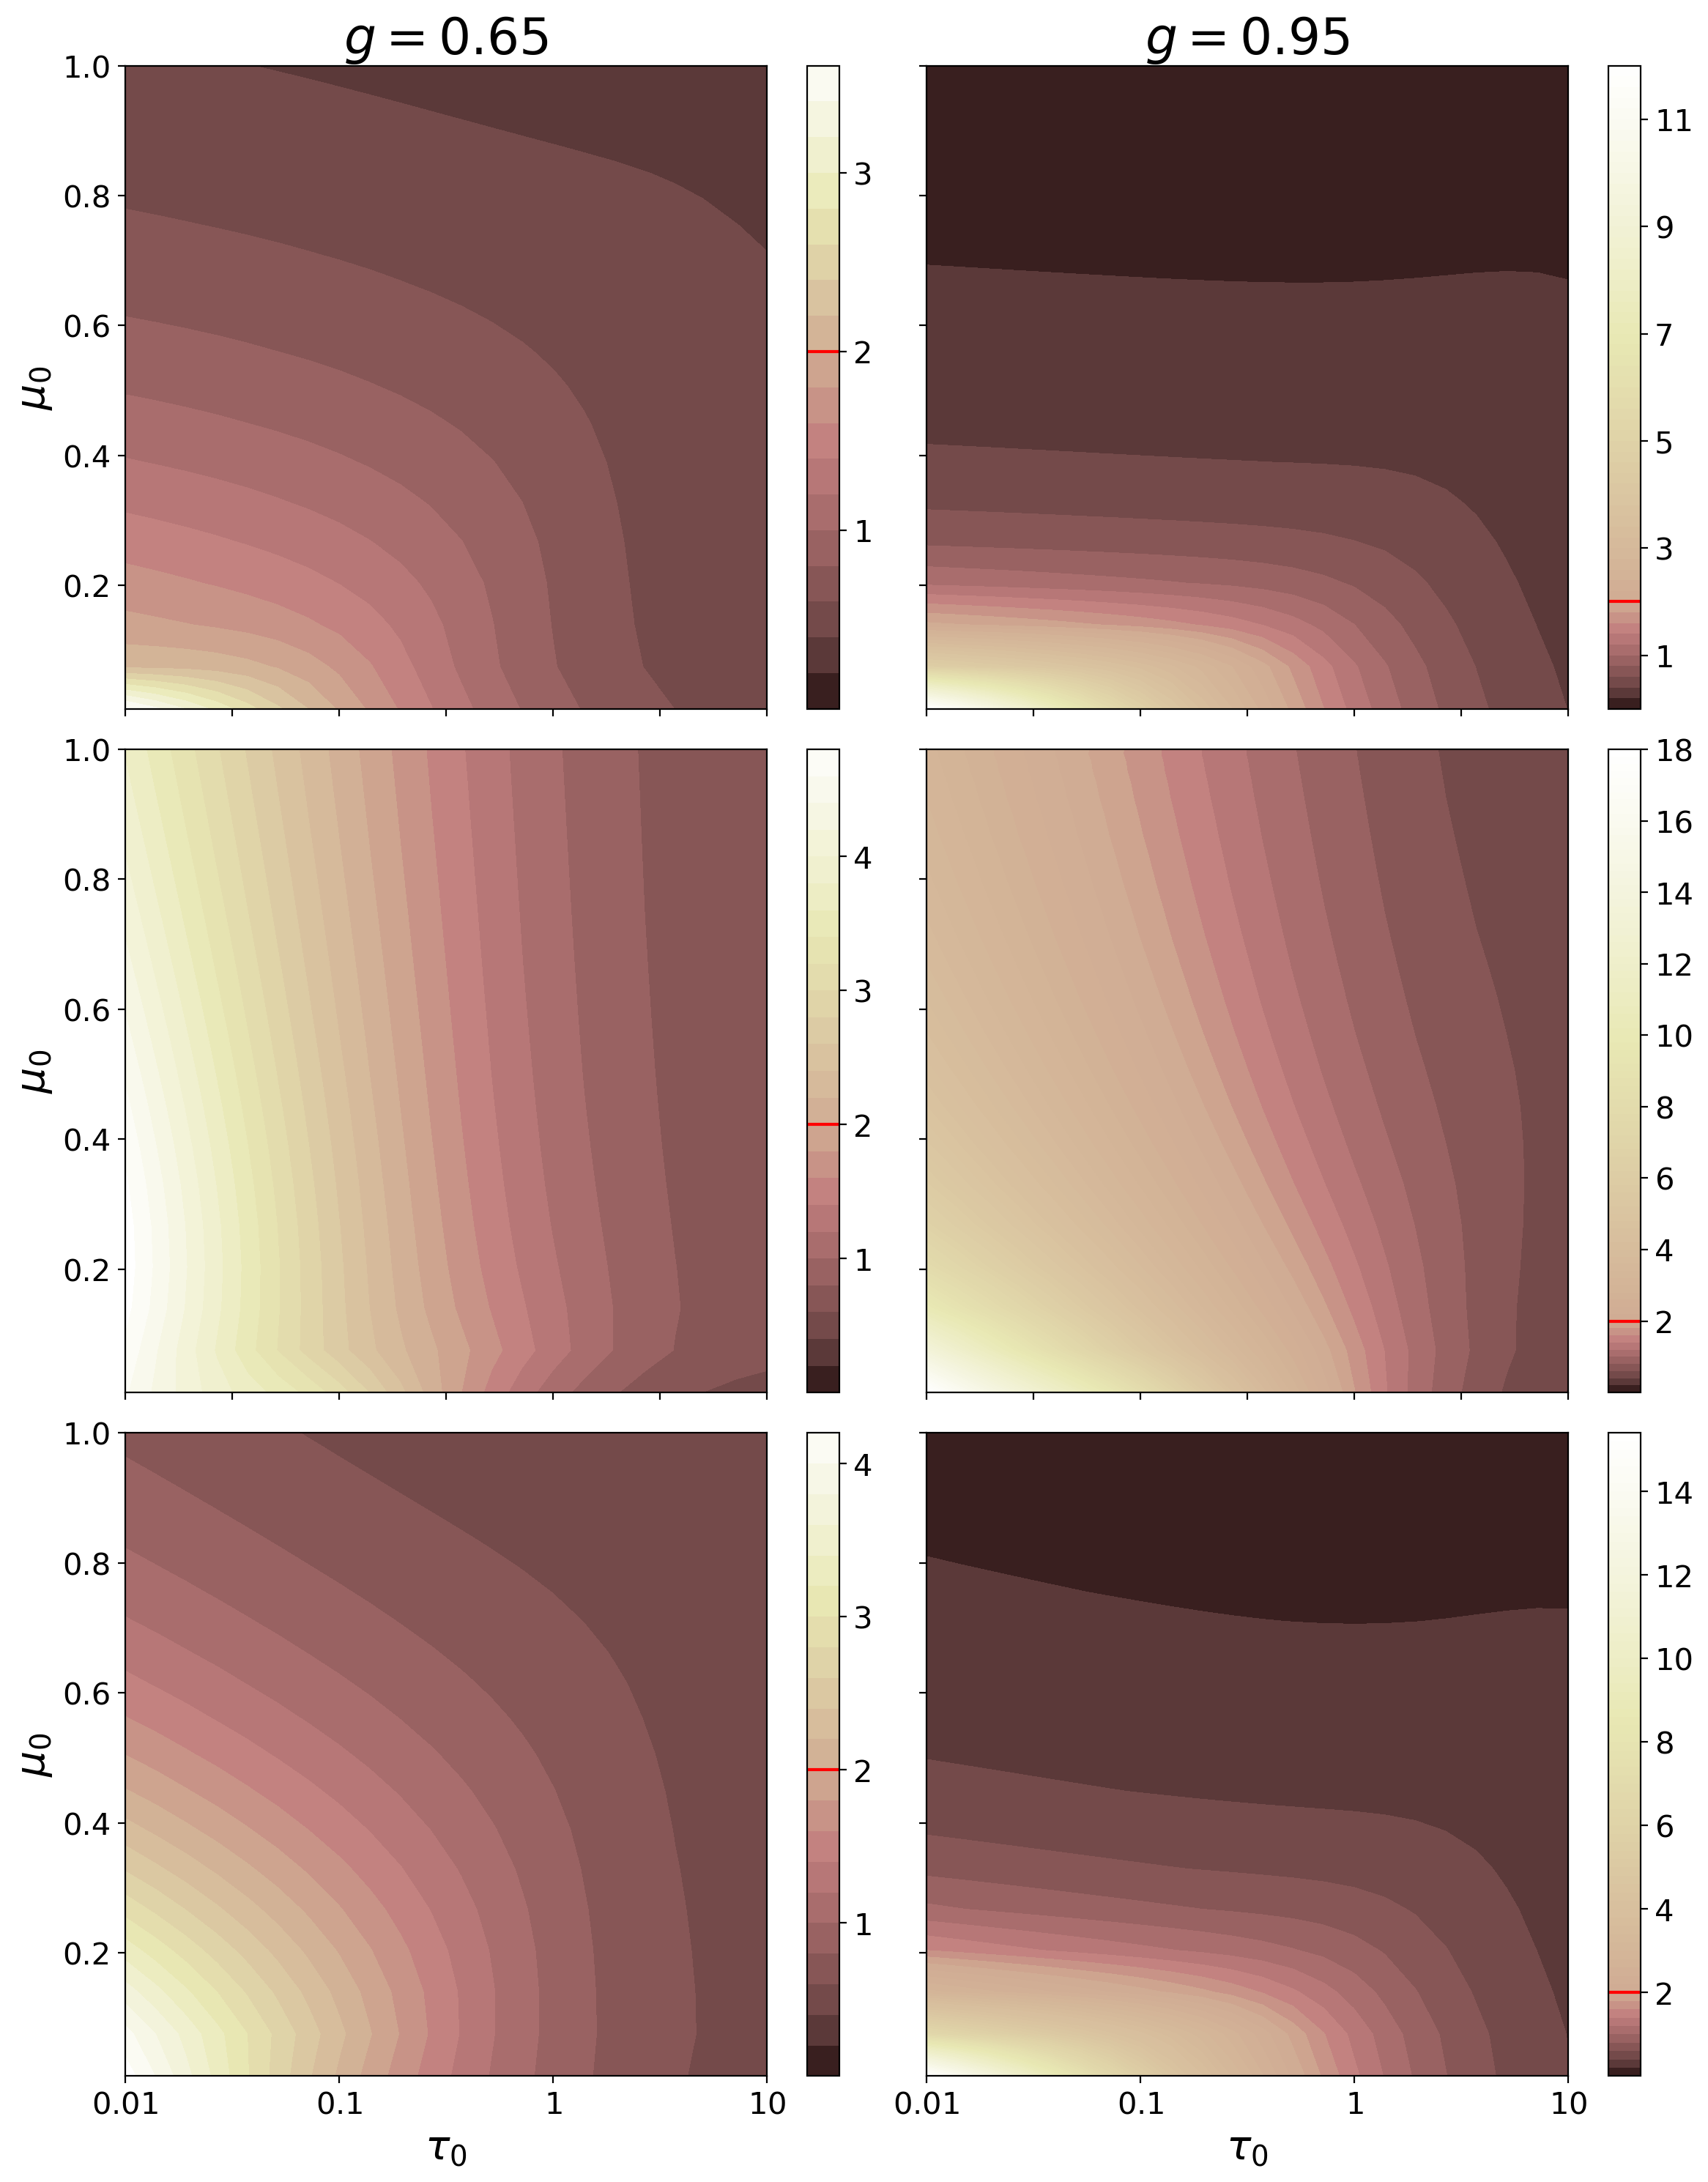

In [46]:
# Variation against macro parameters: tau0, mu0 (Fig. 6)
fig = plt.figure(figsize=(12, 15), dpi=200)
ax1 = plt.subplot((321))
ax1.tick_params(labelbottom=False)
CS = plt.contourf(
    T,
    M,
    gamma1_opt_data[0, :, -3, :].T,
    np.concatenate(
        (
            np.linspace(0, 2, 11)[:-1],
            np.arange(2, np.max(gamma1_opt_data[0, :, -3, :]), 0.2),
        )
    ),
    norm=mpl.colors.TwoSlopeNorm(
        vmin=0, vcenter=2, vmax=np.max(gamma1_opt_data[0, :, -3, :])
    ),
    cmap=mpl.colormaps["pink"],
)
plt.title(r"$g = 0.65$", fontsize=25)
plt.ylabel(r"$\mu_0$", fontsize=20)
plt.yticks(fontsize=15)
cbar = fig.colorbar(CS)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_yticks(np.linspace(1, 3, 3))
cbar.ax.axhline(2, c="r")

ax2 = plt.subplot((322))
ax2.tick_params(labelleft=False, labelbottom=False)
CS2 = plt.contourf(
    T,
    M,
    gamma1_opt_data[-1, :, -3, :].T,
    np.concatenate(
        (
            np.linspace(0, 2, 11)[:-1],
            np.arange(2, np.max(gamma1_opt_data[-1, :, -3, :]), 0.2),
        )
    ),
    norm=mpl.colors.TwoSlopeNorm(
        vmin=0, vcenter=2, vmax=np.max(gamma1_opt_data[-1, :, -3, :])
    ),
    cmap=mpl.colormaps["pink"],
)
plt.title(r"$g = 0.95$", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
CS2.cmap.set_under("black")
cbar2 = fig.colorbar(CS2)
cbar2.ax.tick_params(labelsize=15)
cbar2.ax.set_yticks(np.linspace(1, 11, 6))
cbar2.ax.axhline(2, c="r")

#####

ax3 = plt.subplot((323))
ax3.tick_params(labelbottom=False)
CS3 = plt.contourf(
    T,
    M,
    gamma1p_opt_data[0, :, -3, :].T,
    np.concatenate(
        (
            np.linspace(0, 2, 11)[:-1],
            np.arange(2, np.max(gamma1p_opt_data[0, :, -3, :]), 0.2),
        )
    ),
    norm=mpl.colors.TwoSlopeNorm(
        vmin=0, vcenter=2, vmax=np.max(gamma1p_opt_data[0, :, -3, :])
    ),
    cmap=mpl.colormaps["pink"],
)
plt.ylabel(r"$\mu_0$", fontsize=20)
plt.yticks(fontsize=15)
cbar3 = fig.colorbar(CS3)
cbar3.ax.tick_params(labelsize=15)
cbar3.ax.set_yticks(np.linspace(1, 4, 4))
cbar3.ax.axhline(2, c="r")

ax4 = plt.subplot((324))
ax4.tick_params(labelleft=False, labelbottom=False)
CS4 = plt.contourf(
    T,
    M,
    gamma1p_opt_data[-1, :, -3, :].T,
    np.concatenate(
        (
            np.linspace(0, 2, 11)[:-1],
            np.arange(2, np.max(gamma1p_opt_data[-1, :, -3, :]), 0.2),
        )
    ),
    norm=mpl.colors.TwoSlopeNorm(
        vmin=0, vcenter=2, vmax=np.max(gamma1p_opt_data[-1, :, -3, :])
    ),
    cmap=mpl.colormaps["pink"],
)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
CS4.cmap.set_under("black")
cbar4 = fig.colorbar(CS4)
cbar4.ax.tick_params(labelsize=15)
cbar4.ax.set_yticks(np.linspace(2, 18, 9))
cbar4.ax.axhline(2, c="r")

#####

ax5 = plt.subplot((325))
CS5 = plt.contourf(
    T,
    M,
    gamma1m_opt_data[0, :, -3, :].T,
    np.concatenate(
        (
            np.linspace(0, 2, 11)[:-1],
            np.arange(2, np.max(gamma1m_opt_data[0, :, -3, :]), 0.2),
        )
    ),
    norm=mpl.colors.TwoSlopeNorm(
        vmin=0, vcenter=2, vmax=np.max(gamma1m_opt_data[0, :, -3, :])
    ),
    cmap=mpl.colormaps["pink"],
)
plt.xlabel(r"$\tau_0$", fontsize=20)
plt.ylabel(r"$\mu_0$", fontsize=20)
plt.xticks(
    np.arange(-2, 2, 1),
    labels=[r"$0.01$", r"$0.1$", r"$1$", r"$10$"],
    fontsize=15,
)
plt.yticks(fontsize=15)
cbar5 = fig.colorbar(CS5)
cbar5.ax.tick_params(labelsize=15)
cbar5.ax.set_yticks(np.linspace(1, 4, 4))
cbar5.ax.axhline(2, c="r")

ax6 = plt.subplot((326))
ax6.tick_params(labelleft=False)
CS6 = plt.contourf(
    T,
    M,
    gamma1m_opt_data[-1, :, -3, :].T,
    np.concatenate(
        (
            np.linspace(0, 2, 11)[:-1],
            np.arange(2, np.max(gamma1m_opt_data[-1, :, -3, :]), 0.2),
        )
    ),
    norm=mpl.colors.TwoSlopeNorm(
        vmin=0, vcenter=2, vmax=np.max(gamma1m_opt_data[-1, :, -3, :])
    ),
    cmap=mpl.colormaps["pink"],
)
plt.xlabel(r"$\tau_0$", fontsize=20)
plt.xticks(
    np.arange(-2, 2, 1),
    labels=[r"$0.01$", r"$0.1$", r"$1$", r"$10$"],
    fontsize=15,
)
plt.yticks(fontsize=15)
CS6.cmap.set_under("black")
cbar6 = fig.colorbar(CS6)
cbar6.ax.tick_params(labelsize=15)
cbar6.ax.set_yticks(np.linspace(2, 14, 7))
cbar6.ax.axhline(2, c="r")

fig.tight_layout(w_pad=0)

### Figure 6 but as an INTERACTIVE 3D plot

In [41]:
# Choose which optimized coupling coefficient to plot out of
'''
General:   gamma1p_opt_data, gamma1m_opt_data, gamma2p_opt_data, gamma2m_opt_data,
Symmetric: gamma1_opt_data, gamma2_opt_data
'''

plot_tm = gamma1p_opt_data

*WARNING: this plot is computationally intensive and may not load. Clearing all outputs before running this code block should help.*

In [ ]:
# INTERACTIVE 3D plot of the variation against macro parameters: tau0, mu0 (Fig. 6)
layout = go.Layout(
    scene=dict(
        zaxis=dict(title="Coefficient value"),
        xaxis=dict(title="Single-scattering albedo"),
        yaxis=dict(title="Asymmetry parameter"),
        aspectratio=dict(x=1.5, y=1.5, z=1),
    ),
    font=dict(size=15)
)
fig = go.Figure(layout=layout)

# Add traces, one for each slider step
for step in range(Nt):
    fig.add_trace(
        go.Surface(
            visible=False,
            x=omega_data,
            y=g_data,
            z=plot_tm[:, step, :, 0],
            hovertemplate=("omega: %{x:.3f}<br>g: %{y:.3f}<br><b>gamma: %{z:.3f}<b>"),
        )
    )

# Make 0th trace visible
fig.data[0].visible = True

# Create and add slider for tau0
steps_tau0 = []
for i in range(Nt):
    step = dict(
        method="update",
        args=[
            {"visible": [False] * Nt},
        ],
        label=str(np.around(np.flip(tau0_data)[i], 3)),
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps_tau0.append(step)

# Create and add slider for mu0
steps_mu0 = []
for i in range(Nm):
    plot_tm_it = np.moveaxis(plot_tm[:, :, :, i], 1, 0)
    step = dict(
        method="update",
        args=[
            {"z": plot_tm_it},
        ],
        label=str(np.around(mu0_data[i], 3)),
    )
    steps_mu0.append(step)

sliders = [
    dict(
        active=0,
        currentvalue={"prefix": "tau0: "},
        steps=steps_tau0,
    ),
    dict(
        active=0,
        currentvalue={"prefix": "mu0: "},
        steps=steps_mu0,
        pad={"t": 100},
    ),
]

fig.update_layout(
    sliders=sliders,
    width=1000,
    height=800,
)

# Diffusion Approximation

Plotting the diffusion approximation requires data that is not normally provided by PythonicDISORT, or its FORTRAN antecedent DISORT, but can be extracted from them. Here, we provided the necessary data to plot Fig. 7.

In [43]:
# Data to plot Fig. 7
omega = 0.7488113568490418
mu_arr_pos, weights_mu = PythonicDISORT.subroutines.Gauss_Legendre_quad(53)
S_cache_fig7 = S(0.65 ** np.arange(250))(mu_arr_pos)
tau_arr1 = np.linspace(0, 1, 200)
tau_arr10 = np.linspace(0, 10, 200)

a_s_plus = np.array([1.69245647e-04, 1.68715521e-04, 1.67768912e-04, 1.66417630e-04,
       1.64678579e-04, 1.62573149e-04, 1.60126647e-04, 1.57367662e-04,
       1.54327382e-04, 1.51038883e-04, 1.47536412e-04, 1.43854704e-04,
       1.40028335e-04, 1.36091143e-04, 1.32075713e-04, 1.28012955e-04,
       1.23931759e-04, 1.19858741e-04, 1.15818067e-04, 1.11831354e-04,
       1.07917643e-04, 1.04093425e-04, 1.00372721e-04, 9.67672023e-05,
       9.32863341e-05, 8.99375508e-05, 8.67264375e-05, 8.36569212e-05,
       8.07314630e-05, 7.79512467e-05, 7.53163595e-05, 7.28259644e-05,
       7.04784590e-05, 6.82716227e-05, 6.62027500e-05, 6.42687700e-05,
       6.24663528e-05, 6.07920030e-05, 5.92421411e-05, 5.78131746e-05,
       5.65015575e-05, 5.53038421e-05, 5.42167220e-05, 5.32370680e-05,
       5.23619577e-05, 5.15887005e-05, 5.09148564e-05, 5.03382525e-05,
       4.98569957e-05, 4.94694815e-05, 4.91744018e-05, 4.89707469e-05,
       4.88577740e-05])
a_s_minus = np.array([0.00016949, 0.00017003, 0.00017099, 0.00017239, 0.00017423,
       0.00017653, 0.00017929, 0.00018254, 0.0001863 , 0.00019058,
       0.00019541, 0.00020082, 0.00020684, 0.00021351, 0.00022086,
       0.00022893, 0.00023777, 0.00024742, 0.00025794, 0.00026937,
       0.00028177, 0.00029519, 0.00030969, 0.00032534, 0.00034217,
       0.00036026, 0.00037965, 0.00040038, 0.00042249, 0.00044602,
       0.00047097, 0.00049734, 0.00052512, 0.00055425, 0.00058467,
       0.00061629, 0.00064895, 0.0006825 , 0.00071672, 0.00075136,
       0.00078612, 0.00082068, 0.00085465, 0.00088764, 0.00091921,
       0.00094893, 0.00097634, 0.001001  , 0.00102249, 0.00104043,
       0.00105449, 0.00106441, 0.00106998])
gamma2m_tau1 = np.array([5.35619695, 2.96187003, 2.45582563, 2.15034992, 1.93160902,
       1.76294901, 1.62778303, 1.51690145, 1.42443169, 1.34628772,
       1.27947557, 1.22173479, 1.17132848, 1.12690712, 1.08741386,
       1.05201552, 1.02005093, 0.99099195, 0.96441359, 0.93997124,
       0.91738324, 0.89641745, 0.87688094, 0.85861206, 0.84147427,
       0.82535133, 0.8101436 , 0.79576504, 0.78214089, 0.7692058 ,
       0.75690233, 0.74517973, 0.73399295, 0.72330181, 0.71307037,
       0.70326628, 0.69386041, 0.68482638, 0.67614025, 0.66778022,
       0.65972641, 0.65196062, 0.64446615, 0.63722766, 0.630231  ,
       0.62346313, 0.61691197, 0.61056634, 0.60441584, 0.59845082,
       0.59266229, 0.58704186, 0.58158169, 0.57627446, 0.57111331,
       0.56609179, 0.56120386, 0.55644384, 0.55180639, 0.54728647,
       0.54287932, 0.53858046, 0.53438565, 0.53029088, 0.52629235,
       0.52238647, 0.51856983, 0.51483918, 0.51119144, 0.5076237 ,
       0.50413317, 0.5007172 , 0.49737326, 0.49409895, 0.49089196,
       0.48775012, 0.48467132, 0.48165355, 0.47869491, 0.47579356,
       0.47294774, 0.47015577, 0.46741604, 0.46472701, 0.46208719,
       0.45949514, 0.45694952, 0.45444899, 0.45199229, 0.44957822,
       0.44720558, 0.44487327, 0.44258019, 0.44032529, 0.43810757,
       0.43592606, 0.4337798 , 0.43166791, 0.4295895 , 0.42754373,
       0.42552978, 0.42354686, 0.42159421, 0.41967109, 0.41777679,
       0.41591061, 0.41407189, 0.41225997, 0.41047423, 0.40871406,
       0.40697887, 0.40526808, 0.40358114, 0.40191751, 0.40027666,
       0.3986581 , 0.39706131, 0.39548583, 0.39393119, 0.39239693,
       0.39088261, 0.38938781, 0.3879121 , 0.38645508, 0.38501636,
       0.38359554, 0.38219225, 0.38080613, 0.37943682, 0.37808397,
       0.37674724, 0.3754263 , 0.37412083, 0.37283051, 0.37155503,
       0.37029409, 0.3690474 , 0.36781467, 0.36659562, 0.36538996,
       0.36419744, 0.36301779, 0.36185074, 0.36069605, 0.35955346,
       0.35842274, 0.35730364, 0.35619592, 0.35509936, 0.35401374,
       0.35293882, 0.35187438, 0.35082022, 0.34977611, 0.34874185,
       0.34771724, 0.34670205, 0.34569611, 0.34469919, 0.34371111,
       0.34273167, 0.34176067, 0.34079793, 0.33984324, 0.33889642,
       0.33795728, 0.33702563, 0.33610127, 0.33518401, 0.33427367,
       0.33337005, 0.33247296, 0.3315822 , 0.33069757, 0.32981887,
       0.3289459 , 0.32807845, 0.32721629, 0.32635922, 0.325507  ,
       0.32465939, 0.32381615, 0.32297703, 0.32214173, 0.32130999,
       0.32048147, 0.31965587, 0.3188328 , 0.31801187, 0.31719265,
       0.31637463, 0.31555724, 0.31473983, 0.3139216 , 0.31310161,
       0.31227861, 0.31145099, 0.31061639, 0.30977091, 0.30890508])
gamma1p_tau1 = np.array([3.88396286, 3.67705301, 3.42115126, 3.13427685, 2.84459391,
       2.58071546, 2.36134394, 2.19175587, 2.06720485, 1.97849205,
       1.91608865, 1.87206137, 1.84050431, 1.81729195, 1.79964767,
       1.78574204, 1.77438281, 1.76479587, 1.75647764, 1.74909826,
       1.74243915, 1.73635307, 1.73073871, 1.72552454, 1.72065857,
       1.71610181, 1.71182406, 1.70780119, 1.70401345, 1.70044422,
       1.69707925, 1.69390617, 1.69091405, 1.68809317, 1.68543481,
       1.68293108, 1.68057484, 1.67835958, 1.67627935, 1.67432869,
       1.6725026 , 1.67079647, 1.66920603, 1.66772737, 1.66635686,
       1.66509113, 1.66392707, 1.6628618 , 1.66189264, 1.6610171 ,
       1.66023287, 1.65953782, 1.65892995, 1.65840741, 1.65796849,
       1.6576116 , 1.65733527, 1.65713813, 1.65701891, 1.65697647,
       1.65700971, 1.65711767, 1.65729942, 1.65755416, 1.65788112,
       1.65827963, 1.65874909, 1.65928894, 1.6598987 , 1.66057795,
       1.66132634, 1.66214356, 1.66302935, 1.66398352, 1.66500594,
       1.6660965 , 1.66725516, 1.66848194, 1.66977689, 1.67114011,
       1.67257175, 1.67407201, 1.67564115, 1.67727944, 1.67898722,
       1.68076489, 1.68261286, 1.68453162, 1.68652169, 1.68858364,
       1.6907181 , 1.69292571, 1.69520721, 1.69756336, 1.69999497,
       1.70250291, 1.7050881 , 1.70775152, 1.71049419, 1.71331721,
       1.71622171, 1.71920891, 1.72228006, 1.72543649, 1.7286796 ,
       1.73201086, 1.73543179, 1.738944  , 1.74254917, 1.74624906,
       1.75004551, 1.75394045, 1.75793589, 1.76203394, 1.76623679,
       1.77054675, 1.77496623, 1.77949774, 1.78414392, 1.78890752,
       1.79379143, 1.79879864, 1.80393232, 1.80919577, 1.81459244,
       1.82012596, 1.82580011, 1.83161886, 1.8375864 , 1.84370708,
       1.84998549, 1.85642646, 1.86303503, 1.86981653, 1.87677655,
       1.88392098, 1.891256  , 1.89878814, 1.90652429, 1.9144717 ,
       1.92263805, 1.93103142, 1.93966039, 1.94853401, 1.95766189,
       1.96705422, 1.97672179, 1.98667608, 1.9969293 , 2.00749445,
       2.01838537, 2.02961685, 2.04120467, 2.05316573, 2.06551811,
       2.07828124, 2.09147596, 2.10512471, 2.11925167, 2.13388293,
       2.14904673, 2.16477364, 2.18109688, 2.19805256, 2.21568006,
       2.23402241, 2.25312676, 2.27304489, 2.29383381, 2.31555651,
       2.33828279, 2.36209023, 2.38706537, 2.41330516, 2.44091859,
       2.47002877, 2.5007754 , 2.53331786, 2.56783894, 2.6045496 ,
       2.64369499, 2.68556198, 2.73048911, 2.77887948, 2.83121791,
       2.88809425, 2.95023538, 3.01855047, 3.09419626, 3.17867425,
       3.27398017, 3.38284311, 3.50912741, 3.65855001, 3.84006814,
       4.06887385, 4.37391514, 4.82132839, 5.62184297, 9.90387891])
gamma2m_tau10 = np.array([5.35621434, 1.279612  , 0.91769077, 0.75738014, 0.66038242,
       0.59350868, 0.54393135, 0.50540901, 0.47446868, 0.4489965 ,
       0.42761977, 0.40940218, 0.39367994, 0.37996749, 0.36790039,
       0.35719911, 0.34764521, 0.33906528, 0.33131972, 0.32429475,
       0.31789662, 0.31204733, 0.30668141, 0.30174351, 0.29718642,
       0.29296968, 0.28905838, 0.2854222 , 0.28203474, 0.27887283,
       0.2759161 , 0.27314654, 0.27054817, 0.26810677, 0.26580963,
       0.26364536, 0.26160373, 0.25967551, 0.25785236, 0.25612672,
       0.25449174, 0.25294116, 0.25146929, 0.25007091, 0.24874126,
       0.24747595, 0.24627096, 0.24512259, 0.24402741, 0.24298227,
       0.24198424, 0.24103062, 0.24011889, 0.23924673, 0.23841195,
       0.23761255, 0.23684663, 0.23611243, 0.23540832, 0.23473275,
       0.23408428, 0.23346156, 0.23286332, 0.23228838, 0.23173561,
       0.23120397, 0.23069245, 0.23020014, 0.22972614, 0.22926962,
       0.2288298 , 0.22840595, 0.22799734, 0.22760333, 0.22722328,
       0.2268566 , 0.22650271, 0.22616109, 0.22583122, 0.22551261,
       0.22520482, 0.22490739, 0.22461992, 0.224342  , 0.22407327,
       0.22381335, 0.2235619 , 0.2233186 , 0.22308313, 0.2228552 ,
       0.22263451, 0.2224208 , 0.2222138 , 0.22201327, 0.22181896,
       0.22163065, 0.22144812, 0.22127115, 0.22109954, 0.2209331 ,
       0.22077165, 0.220615  , 0.22046299, 0.22031545, 0.22017221,
       0.22003313, 0.21989807, 0.21976687, 0.2196394 , 0.21951554,
       0.21939514, 0.2192781 , 0.21916429, 0.2190536 , 0.21894592,
       0.21884113, 0.21873914, 0.21863985, 0.21854315, 0.21844896,
       0.21835717, 0.2182677 , 0.21818047, 0.21809538, 0.21801235,
       0.2179313 , 0.21785216, 0.21777483, 0.21769926, 0.21762535,
       0.21755304, 0.21748225, 0.21741291, 0.21734494, 0.21727828,
       0.21721286, 0.2171486 , 0.21708543, 0.21702328, 0.21696209,
       0.21690177, 0.21684226, 0.21678349, 0.21672537, 0.21666785,
       0.21661083, 0.21655424, 0.216498  , 0.21644203, 0.21638624,
       0.21633055, 0.21627486, 0.21621908, 0.21616312, 0.21610686,
       0.21605021, 0.21599305, 0.21593526, 0.21587672, 0.21581729,
       0.21575684, 0.21569522, 0.21563226, 0.2155678 , 0.21550166,
       0.21543365, 0.21536355, 0.21529114, 0.21521618, 0.2151384 ,
       0.21505752, 0.21497323, 0.21488518, 0.214793  , 0.21469629,
       0.21459459, 0.21448739, 0.21437415, 0.21425423, 0.21412696,
       0.21399154, 0.2138471 , 0.21369262, 0.21352697, 0.21334881,
       0.21315661, 0.21294857, 0.21272259, 0.21247611, 0.21220609,
       0.21190877, 0.21157946, 0.21121219, 0.21079914, 0.21032975,
       0.20978907, 0.20915469, 0.20838961, 0.20742185, 0.20602452])
gamma1p_tau10 = np.array([3.81640597, 1.76585781, 1.5817695 , 1.51818984, 1.47362186,
       1.43937793, 1.41180898, 1.38892625, 1.36951662, 1.35278235,
       1.33816963, 1.32527775, 1.31380726, 1.30352845, 1.29426123,
       1.28586188, 1.2782139 , 1.27122159, 1.26480547, 1.25889879,
       1.25344504, 1.24839598, 1.24371012, 1.23935157, 1.23528907,
       1.23149528, 1.22794612, 1.22462035, 1.22149911, 1.21856561,
       1.21580484, 1.21320333, 1.21074898, 1.20843086, 1.20623908,
       1.20416469, 1.20219953, 1.20033618, 1.19856786, 1.19688836,
       1.19529198, 1.19377352, 1.19232815, 1.19095145, 1.18963933,
       1.18838802, 1.187194  , 1.18605404, 1.18496514, 1.18392449,
       1.18292949, 1.18197773, 1.18106694, 1.18019502, 1.17936   ,
       1.17856005, 1.17779344, 1.17705856, 1.17635392, 1.17567808,
       1.17502974, 1.17440764, 1.17381062, 1.17323758, 1.17268749,
       1.17215938, 1.17165235, 1.17116554, 1.17069815, 1.17024942,
       1.16981865, 1.16940516, 1.16900834, 1.1686276 , 1.16826239,
       1.16791219, 1.16757653, 1.16725495, 1.16694705, 1.16665242,
       1.16637071, 1.16610159, 1.16584475, 1.1655999 , 1.1653668 ,
       1.1651452 , 1.1649349 , 1.16473572, 1.16454748, 1.16437005,
       1.16420332, 1.16404718, 1.16390155, 1.1637664 , 1.16364168,
       1.16352739, 1.16342354, 1.16333017, 1.16324734, 1.16317512,
       1.16311363, 1.163063  , 1.16302338, 1.16299495, 1.16297791,
       1.16297251, 1.162979  , 1.16299768, 1.16302887, 1.16307291,
       1.1631302 , 1.16320116, 1.16328624, 1.16338594, 1.16350079,
       1.16363136, 1.16377827, 1.16394218, 1.16412382, 1.16432393,
       1.16454333, 1.16478291, 1.16504359, 1.16532636, 1.16563229,
       1.16596252, 1.16631826, 1.16670079, 1.1671115 , 1.16755185,
       1.16802341, 1.16852784, 1.16906692, 1.16964255, 1.17025675,
       1.17091167, 1.17160961, 1.17235304, 1.17314456, 1.17398698,
       1.17488328, 1.17583666, 1.17685053, 1.17792855, 1.17907463,
       1.18029296, 1.18158803, 1.18296466, 1.18442804, 1.18598371,
       1.18763766, 1.18939634, 1.19126668, 1.19325618, 1.19537293,
       1.19762569, 1.20002393, 1.20257794, 1.20529889, 1.20819894,
       1.21129134, 1.21459056, 1.21811243, 1.22187429, 1.22589522,
       1.23019621, 1.23480042, 1.23973353, 1.245024  , 1.25070353,
       1.25680753, 1.26337569, 1.27045265, 1.27808883, 1.28634142,
       1.29527558, 1.30496595, 1.31549845, 1.32697262, 1.33950447,
       1.35323021, 1.36831101, 1.38493915, 1.40334634, 1.42381467,
       1.44669178, 1.47241197, 1.50152618, 1.53474606, 1.57301023,
       1.61758769, 1.67024603, 1.73353899, 1.81132988, 1.90982352,
       2.03982893, 2.22252384, 2.50797759, 3.06683256, 9.50617716])

In [44]:
# Compute diffusion approximations
gamma1p_DA = ((1 - omega / 2 * (1 + S_cache_fig7)) * weights_mu @ a_s_plus) / (
    mu_arr_pos * weights_mu @ a_s_plus
)
gamma1m_DA = ((1 - omega / 2 * (1 + S_cache_fig7)) * weights_mu @ a_s_minus) / (
    mu_arr_pos * weights_mu @ a_s_minus
)
gamma2p_DA = ((omega / 2) * (1 - S_cache_fig7) * weights_mu @ a_s_plus) / (
    mu_arr_pos * weights_mu @ a_s_plus
)
gamma2m_DA = ((omega / 2) * (1 - S_cache_fig7) * weights_mu @ a_s_minus) / (
    mu_arr_pos * weights_mu @ a_s_minus
)

## Figure 7

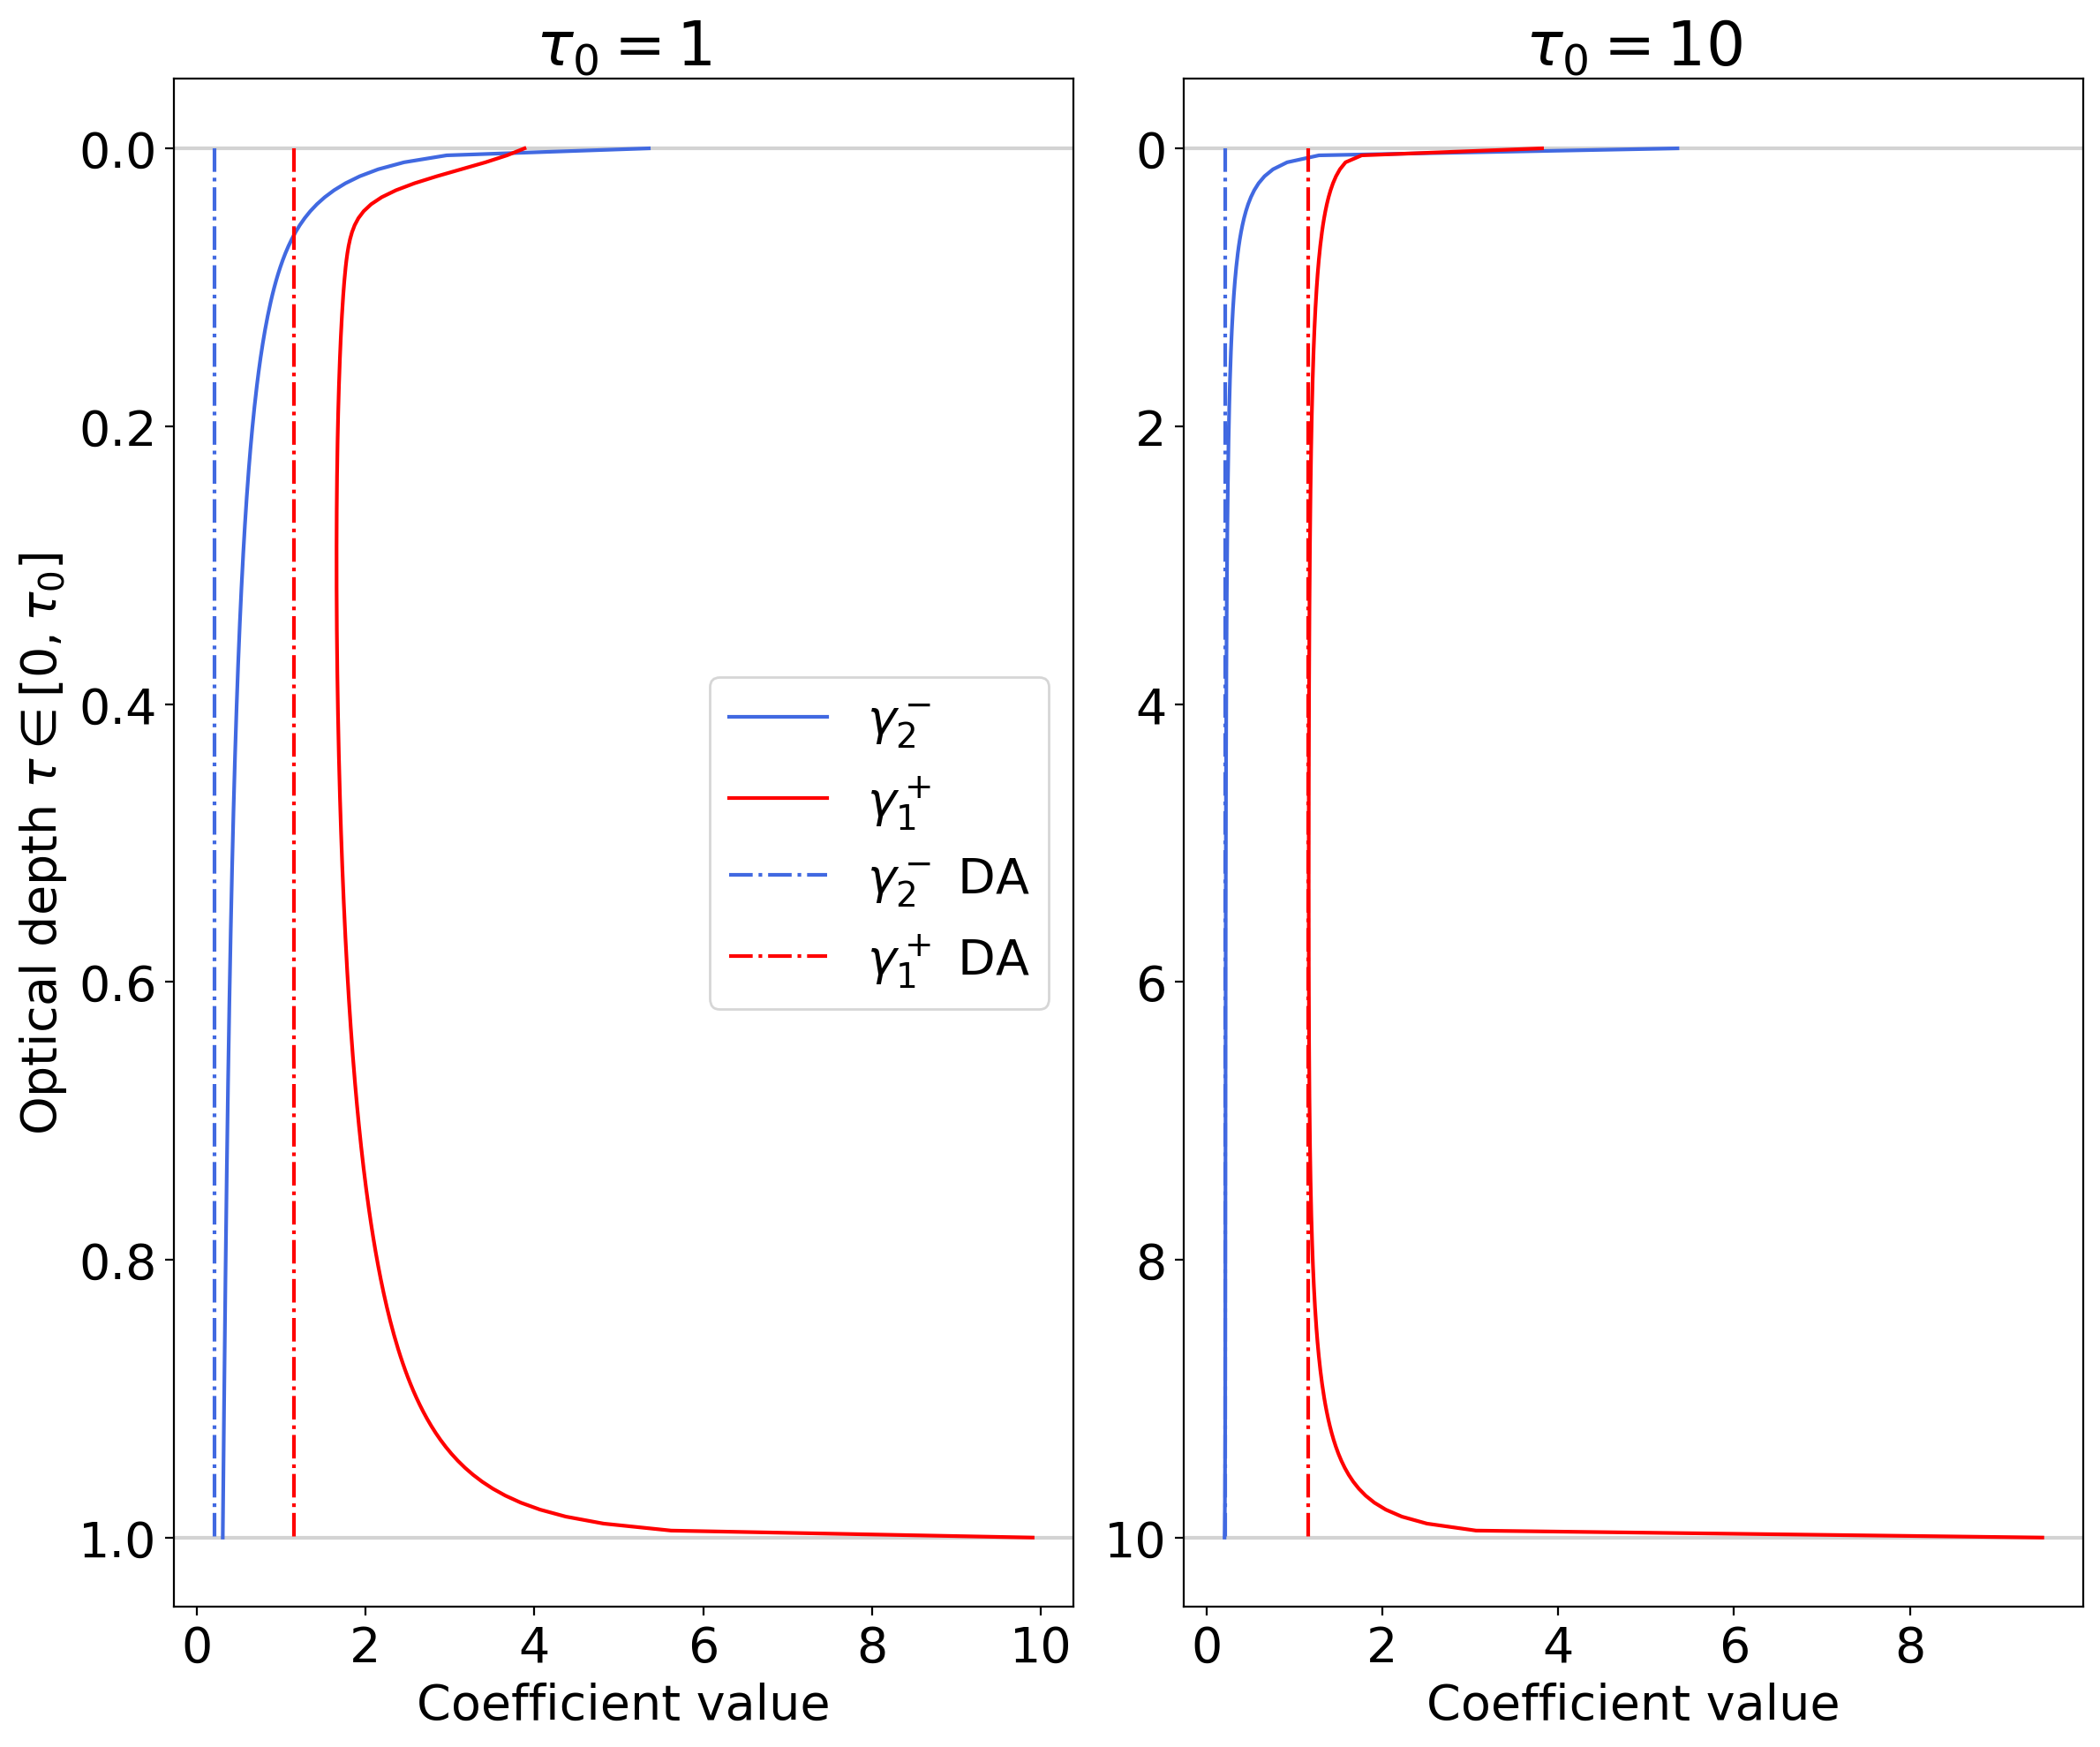

In [45]:
# Plot exact coupling coefficients with corresponding diffusion approximations (Fig. 7)
fig = plt.figure(figsize=(12, 10), dpi=200)
ax1 = plt.subplot((121))
plt.title(r"$\tau_0 = 1$", fontsize=25)
plt.gca().invert_yaxis()
plt.axhline(1, color="lightgrey")
plt.axhline(0, color="lightgrey")
plt.plot(gamma2m_tau1, tau_arr1, label="$\gamma_2^-$", color="royalblue")
plt.plot(gamma1p_tau1, tau_arr1, label="$\gamma_1^+$", color="red")
plt.plot(np.repeat(gamma2m_DA, len(tau_arr1)), tau_arr1, "-.", color="royalblue", label="$\gamma_2^-$ DA")
plt.plot(np.repeat(gamma1p_DA, len(tau_arr1)), tau_arr1, "-.", color="red", label="$\gamma_1^+$ DA")
plt.ylabel(r"Optical depth $\tau \in [0, \tau_0]$", fontsize=20)
plt.xlabel("Coefficient value", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

ax2 = plt.subplot((122))
plt.title(r"$\tau_0 = 10$", fontsize=25)
plt.gca().invert_yaxis()
plt.axhline(10, color="lightgrey")
plt.axhline(0, color="lightgrey")
plt.plot(gamma2m_tau10, tau_arr10, label="$\gamma_2^-$", color="royalblue")
plt.plot(gamma1p_tau10, tau_arr10, label="$\gamma_1^+$", color="red")
plt.plot(np.repeat(gamma2m_DA, len(tau_arr10)), tau_arr10, "-.", color="royalblue", label="$\gamma_2^-$ DA")
plt.plot(np.repeat(gamma1p_DA, len(tau_arr10)), tau_arr10, "-.", color="red", label="$\gamma_1^+$ DA")
plt.xlabel("Coefficient value", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fig.tight_layout(h_pad=0)